In [1]:
import os
import cv2
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torchvision

import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
from functions_v2 import(import_train_folder_dataset_2, 
                      Data_2, 
                      plot_loss_accuracy, 
                      accuracy_given_set,
                      import_test_folder_dataset_2,
                      Data_test_2,
                      make_predictions,
                      save_predictions_as_csv,
                      save_model,
                      save_metrics)

# 1. Build your own convolutional neural network using pytorch

In [4]:
# Learning parameters.
epochs = 500 # Number of epochs to train the model
lr = 0.01 # Learning rate.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 8

checkpoints_save = 100 # Save after 100 epochs


model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Computer Vision/Project/Project 1/CheckPoints/"

cuda


In [5]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        
        '''
        In dimension:              224 * 224 * 3 
        Out dimension Conv:        224 * 224 * 16
        Out dimension MaxPooling:  112 * 112 * 16
        '''
        self.cnn1_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        )
        self.cnn1_Res = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=1, stride=1, padding=0) 
        self.maxpool1 = nn.MaxPool2d(2, stride=2)
        
        
        '''
        In dimension:              112 * 112 * 16
        Out dimension Conv:        112 * 112 * 32
        Out dimension MaxPooling:  56  * 56  * 32
        '''
        self.cnn2_model = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        )
        self.cnn2_Res = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1, stride=1, padding=0) 
        self.maxpool2 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              56  * 56  * 32
        Out dimension Conv:        56  * 56  * 64
        Out dimension MaxPooling:  28  * 28  * 64
        '''
        self.cnn3_model = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        )
        self.cnn3_Res = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=1, padding=0) 
        self.maxpool3 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              28  * 28  * 64
        Out dimension Conv:        28  * 28  * 128
        Out dimension MaxPooling:  14  * 14  * 128
        '''
        self.cnn4_model = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        )
        self.cnn4_Res = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, stride=1, padding=0) 
        self.maxpool4 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              14  * 14  * 128
        Out dimension Conv:        14  * 14  * 128
        Out dimension MaxPooling:  7  * 7  * 128
        '''
        self.cnn5_model = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        )
        self.cnn5_Res = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, stride=1, padding=0) 
        self.maxpool5 = nn.MaxPool2d(2, stride=2)
        
        
        self.ffnn_model = nn.Sequential(
            nn.Linear(in_features=6272, out_features=512),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=4)
        )
        
        
        
    def forward(self, x): 
        
        residual = x
        # Convolution
        x = self.cnn1_model(x)
        # Residual
        residual = self.cnn1_Res(residual)
        x += residual
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool1(x)
        
        
        residual = x
        # Convolution
        x = self.cnn2_model(x)
        # Residual
        residual = self.cnn2_Res(residual)
        x += residual
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool2(x)
        
        
        residual = x
        # Convolution
        x = self.cnn3_model(x)
        # Residual
        residual = self.cnn3_Res(residual)
        x += residual
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool3(x)
        
        
        residual = x
        # Convolution
        x = self.cnn4_model(x)
        # Residual
        residual = self.cnn4_Res(residual)
        x += residual
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool4(x)
        
        
        residual = x
        # Convolution
        x = self.cnn5_model(x)
        # Residual
        residual = self.cnn5_Res(residual)
        x += residual
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool5(x)
        
        
        x = torch.flatten(x,start_dim=1)
        #print("Flatten Out: ",x.shape)
        x = self.ffnn_model(x)
        #print("ffnn out: ",x.shape)
        x = torch.sigmoid(x)
        #print("Sigmoid Out: ",x.shape)
        return x

In [6]:
#PyTorch - Visualizing the Model
modelpy = ClassificationNet().to(device) # Get the model, and if there is a GPU use it
print("model created")
# Loss function.
criterion = nn.CrossEntropyLoss() # Set the loss function to cross entropy loss
# Optimizer.
optim = torch.optim.SGD(modelpy.parameters(), lr=lr)# , momentum=0.9, weight_decay=1e-3


# Check if checkpoint is available, if so, load it
epoch_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt.pth"):
        print("Loading save chackpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_check = checkpoint['epoch']
        criterion = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {epoch_check}")


modelpy

model created


ClassificationNet(
  (cnn1_model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (cnn1_Res): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2_model): Sequential(
    (0): Conv2d(16, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (cnn2_Res): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3_model): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (cnn3_Res): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (maxpool3): MaxPo

In [7]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 4296372


# Load Data

In [8]:
# Path of the files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Test"

In [9]:
img_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomRotation((-20,20)),
                                    transforms.Resize((275, 275)),
                                    #transforms.CenterCrop((224, 224)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [10]:
# Import the data into a resized 224x224 images
size_of_resized_img = (224,224) 
train_data, train_labels = import_train_folder_dataset_2(train_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", train_data.shape)
print("Dim of Lables: ", train_labels.shape)

Dim of Data:  (1149, 224, 224, 3)
Dim of Lables:  (1149,)


In [11]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 224, 224, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 224, 224, 3)
Dim of y_test:  (115,)


In [12]:
# Create the dataset object
train_Dataset = Data_2(X_train, y_train, img_transform) # img_transform_2 img_transform
val_Dataset = Data_2(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [13]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

In [14]:
print("Type of object: ",type(train_loader))

print()
print( 'Train Size: ' + str(len(train_loader)))
print( 'Validate Size: ' + str(len(valid_loader)))

print()
print("Content of one element: ",iter(train_loader).next())

print()
print("Type of one element: ", type(iter(train_loader).next()))
print("Length of one element: ", len(iter(train_loader).next()))

print()
print('Input tensors size: ' + str(iter(train_loader).next()[0].shape)) # Input: 16, 16875 | 16 train batch size, 16875 = 75x75 image dimension, 3 channels (colors) 
print('Label tensors size: ' + str(iter(train_loader).next()[1].shape)) # Label: 16 | 16 train Batch size


print()
print('Input tensors size: ' + str(iter(valid_loader).next()[0].shape)) # Input: 8, 16875 | 8 validation batch size, 16875 = 75x75 image dimension, 3 channels (colors) 
print('Label tensors size: ' + str(iter(valid_loader).next()[1].shape)) # Label: 8 | 8 validation Batch size


Type of object:  <class 'torch.utils.data.dataloader.DataLoader'>

Train Size: 65
Validate Size: 15

Content of one element:  [tensor([[[[ 0.2624,  0.2796,  0.2796,  ..., -0.5082, -0.5253, -0.5767],
          [ 0.2624,  0.2624,  0.2624,  ..., -0.5596, -0.5767, -0.5767],
          [ 0.2796,  0.2624,  0.2624,  ..., -0.6452, -0.6452, -0.6281],
          ...,
          [-2.1179, -1.7240, -1.1760,  ...,  0.3652,  0.5022,  0.6221],
          [-2.1179, -1.7412, -1.2274,  ...,  0.4508,  0.5536,  0.6221],
          [-2.1179, -1.7240, -1.2103,  ...,  0.4851,  0.5536,  0.6049]],

         [[ 0.1176,  0.1352,  0.1352,  ..., -0.2675, -0.2675, -0.3200],
          [ 0.1176,  0.1176,  0.1176,  ..., -0.3200, -0.2850, -0.3025],
          [ 0.1352,  0.1176,  0.1176,  ..., -0.3901, -0.3550, -0.3375],
          ...,
          [-2.0357, -1.5630, -0.9503,  ...,  0.9755,  1.1155,  1.2206],
          [-2.0357, -1.5805, -1.0028,  ...,  1.0630,  1.1856,  1.2556],
          [-2.0357, -1.5805, -0.9678,  ...,  1.09

# 2. Train your model using cow teat datasets (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 


Epoch 1 of 500


100%|██████████| 15/15 [00:00<00:00, 18.16it/s]


train loss:  0.08670366778825653
Val loss:  0.17884441458660624
train accuracy:  0.3839458413926499
Val accuracy:  0.40869565217391307
Current time: 0.745 minutes. Time expected till completion: 371.648 minutes

Epoch 2 of 500


100%|██████████| 15/15 [00:00<00:00, 16.99it/s]


train loss:  0.08567134208789877
Val loss:  0.1763259804767111
train accuracy:  0.43036750483558994
Val accuracy:  0.45217391304347826
Current time: 1.046 minutes. Time expected till completion: 260.433 minutes

Epoch 3 of 500


100%|██████████| 15/15 [00:00<00:00, 17.11it/s]


train loss:  0.08404643035257808
Val loss:  0.17112858399100925
train accuracy:  0.42263056092843326
Val accuracy:  0.45217391304347826
Current time: 1.350 minutes. Time expected till completion: 223.587 minutes

Epoch 4 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.07984477719670338
Val loss:  0.15781302659407906
train accuracy:  0.4245647969052224
Val accuracy:  0.45217391304347826
Current time: 1.660 minutes. Time expected till completion: 205.800 minutes

Epoch 5 of 500


100%|██████████| 15/15 [00:00<00:00, 16.55it/s]


train loss:  0.07551604509353638
Val loss:  0.15341783710148024
train accuracy:  0.4245647969052224
Val accuracy:  0.45217391304347826
Current time: 1.989 minutes. Time expected till completion: 196.953 minutes

Epoch 6 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.0748598988328266
Val loss:  0.15329961154771887
train accuracy:  0.41779497098646035
Val accuracy:  0.45217391304347826
Current time: 2.300 minutes. Time expected till completion: 189.388 minutes

Epoch 7 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.07479852795370312
Val loss:  0.15347474139669667
train accuracy:  0.41682785299806574
Val accuracy:  0.45217391304347826
Current time: 2.605 minutes. Time expected till completion: 183.449 minutes

Epoch 8 of 500


100%|██████████| 15/15 [00:00<00:00, 15.97it/s]


train loss:  0.07480275262024694
Val loss:  0.15342819794364598
train accuracy:  0.41682785299806574
Val accuracy:  0.45217391304347826
Current time: 2.911 minutes. Time expected till completion: 178.999 minutes

Epoch 9 of 500


100%|██████████| 15/15 [00:00<00:00, 16.49it/s]


train loss:  0.07474065426470464
Val loss:  0.1538587134817372
train accuracy:  0.42359767891682787
Val accuracy:  0.45217391304347826
Current time: 3.217 minutes. Time expected till completion: 175.502 minutes

Epoch 10 of 500


100%|██████████| 15/15 [00:00<00:00, 16.05it/s]


train loss:  0.07466434556234275
Val loss:  0.15317722196164338
train accuracy:  0.4245647969052224
Val accuracy:  0.45217391304347826
Current time: 3.523 minutes. Time expected till completion: 172.628 minutes

Epoch 11 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.07458498053670622
Val loss:  0.15362790356511655
train accuracy:  0.425531914893617
Val accuracy:  0.45217391304347826
Current time: 3.830 minutes. Time expected till completion: 170.254 minutes

Epoch 12 of 500


100%|██████████| 15/15 [00:00<00:00, 16.53it/s]


train loss:  0.07458487758322888
Val loss:  0.15278315958769426
train accuracy:  0.425531914893617
Val accuracy:  0.45217391304347826
Current time: 4.137 minutes. Time expected till completion: 168.219 minutes

Epoch 13 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.0746835296112518
Val loss:  0.15327690476956574
train accuracy:  0.42263056092843326
Val accuracy:  0.45217391304347826
Current time: 4.444 minutes. Time expected till completion: 166.485 minutes

Epoch 14 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.07439657256036017
Val loss:  0.15251194083172342
train accuracy:  0.4197292069632495
Val accuracy:  0.45217391304347826
Current time: 4.751 minutes. Time expected till completion: 164.934 minutes

Epoch 15 of 500


100%|██████████| 15/15 [00:00<00:00, 16.19it/s]


train loss:  0.07454833163514128
Val loss:  0.15291523726090142
train accuracy:  0.425531914893617
Val accuracy:  0.45217391304347826
Current time: 5.059 minutes. Time expected till completion: 163.560 minutes

Epoch 16 of 500


100%|██████████| 15/15 [00:00<00:00, 16.00it/s]


train loss:  0.07447601448405873
Val loss:  0.1523137424303138
train accuracy:  0.42359767891682787
Val accuracy:  0.45217391304347826
Current time: 5.368 minutes. Time expected till completion: 162.385 minutes

Epoch 17 of 500


100%|██████████| 15/15 [00:00<00:00, 16.24it/s]


train loss:  0.07427671292303148
Val loss:  0.15266444164773693
train accuracy:  0.42359767891682787
Val accuracy:  0.45217391304347826
Current time: 5.675 minutes. Time expected till completion: 161.248 minutes

Epoch 18 of 500


100%|██████████| 15/15 [00:00<00:00, 16.21it/s]


train loss:  0.07415243470230692
Val loss:  0.15217389023822286
train accuracy:  0.4245647969052224
Val accuracy:  0.45217391304347826
Current time: 5.984 minutes. Time expected till completion: 160.250 minutes

Epoch 19 of 500


100%|██████████| 15/15 [00:00<00:00, 16.75it/s]


train loss:  0.07393094972208344
Val loss:  0.15160214175348696
train accuracy:  0.4245647969052224
Val accuracy:  0.45217391304347826
Current time: 6.294 minutes. Time expected till completion: 159.346 minutes

Epoch 20 of 500


100%|██████████| 15/15 [00:00<00:00, 16.55it/s]


train loss:  0.0732773189618463
Val loss:  0.14992426167363707
train accuracy:  0.4245647969052224
Val accuracy:  0.45217391304347826
Current time: 6.602 minutes. Time expected till completion: 158.460 minutes

Epoch 21 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.07241467777027152
Val loss:  0.1494922523913176
train accuracy:  0.4245647969052224
Val accuracy:  0.45217391304347826
Current time: 6.916 minutes. Time expected till completion: 157.755 minutes

Epoch 22 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.07174717077203599
Val loss:  0.14743292072544928
train accuracy:  0.4245647969052224
Val accuracy:  0.45217391304347826
Current time: 7.227 minutes. Time expected till completion: 157.017 minutes

Epoch 23 of 500


100%|██████████| 15/15 [00:00<00:00, 16.14it/s]


train loss:  0.071332779739996
Val loss:  0.14572439193725586
train accuracy:  0.425531914893617
Val accuracy:  0.45217391304347826
Current time: 7.538 minutes. Time expected till completion: 156.325 minutes

Epoch 24 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.07091119032302724
Val loss:  0.14484974871511044
train accuracy:  0.43423597678916825
Val accuracy:  0.45217391304347826
Current time: 7.849 minutes. Time expected till completion: 155.662 minutes

Epoch 25 of 500


100%|██████████| 15/15 [00:00<00:00, 16.37it/s]


train loss:  0.07031827738483362
Val loss:  0.14366105017454728
train accuracy:  0.44197292069632493
Val accuracy:  0.48695652173913045
Current time: 8.158 minutes. Time expected till completion: 154.999 minutes

Epoch 26 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.07035166290327474
Val loss:  0.14347288608551026
train accuracy:  0.4661508704061896
Val accuracy:  0.5478260869565217
Current time: 8.467 minutes. Time expected till completion: 154.357 minutes

Epoch 27 of 500


100%|██████████| 15/15 [00:00<00:00, 16.64it/s]


train loss:  0.07046252466032076
Val loss:  0.14386792804883874
train accuracy:  0.4690522243713733
Val accuracy:  0.5478260869565217
Current time: 8.778 minutes. Time expected till completion: 153.778 minutes

Epoch 28 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.07033900412185048
Val loss:  0.14405512291452158
train accuracy:  0.4864603481624758
Val accuracy:  0.5304347826086957
Current time: 9.087 minutes. Time expected till completion: 153.182 minutes

Epoch 29 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.070301098565299
Val loss:  0.14608896141466887
train accuracy:  0.4922630560928433
Val accuracy:  0.46956521739130436
Current time: 9.396 minutes. Time expected till completion: 152.602 minutes

Epoch 30 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.07003987308166475
Val loss:  0.1432087224462758
train accuracy:  0.5164410058027079
Val accuracy:  0.5652173913043478
Current time: 9.705 minutes. Time expected till completion: 152.048 minutes

Epoch 31 of 500


100%|██████████| 15/15 [00:00<00:00, 16.05it/s]


train loss:  0.06995550714562894
Val loss:  0.1429566362629766
train accuracy:  0.504835589941973
Val accuracy:  0.5739130434782609
Current time: 10.016 minutes. Time expected till completion: 151.531 minutes

Epoch 32 of 500


100%|██████████| 15/15 [00:00<00:00, 16.28it/s]


train loss:  0.07014939650115008
Val loss:  0.14593978861103887
train accuracy:  0.5203094777562862
Val accuracy:  0.6608695652173913
Current time: 10.325 minutes. Time expected till completion: 151.000 minutes

Epoch 33 of 500


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


train loss:  0.07051725665420813
Val loss:  0.14363801375679347
train accuracy:  0.5357833655705996
Val accuracy:  0.591304347826087
Current time: 10.637 minutes. Time expected till completion: 150.527 minutes

Epoch 34 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.07004793953849453
Val loss:  0.14349565505981446
train accuracy:  0.5531914893617021
Val accuracy:  0.6086956521739131
Current time: 10.947 minutes. Time expected till completion: 150.042 minutes

Epoch 35 of 500


100%|██████████| 15/15 [00:00<00:00, 16.15it/s]


train loss:  0.06979785626123676
Val loss:  0.14365059085514234
train accuracy:  0.5338491295938105
Val accuracy:  0.6347826086956522
Current time: 11.257 minutes. Time expected till completion: 149.561 minutes

Epoch 36 of 500


100%|██████████| 15/15 [00:00<00:00, 16.28it/s]


train loss:  0.07104222467835683
Val loss:  0.15228520890940792
train accuracy:  0.5193423597678917
Val accuracy:  0.41739130434782606
Current time: 11.568 minutes. Time expected till completion: 149.093 minutes

Epoch 37 of 500


100%|██████████| 15/15 [00:00<00:00, 16.24it/s]


train loss:  0.07494035311317075
Val loss:  0.15228520890940792
train accuracy:  0.40038684719535783
Val accuracy:  0.43478260869565216
Current time: 11.878 minutes. Time expected till completion: 148.636 minutes

Epoch 38 of 500


100%|██████████| 15/15 [00:00<00:00, 16.49it/s]


train loss:  0.07490860378258002
Val loss:  0.15228520890940792
train accuracy:  0.40135396518375244
Val accuracy:  0.4260869565217391
Current time: 12.187 minutes. Time expected till completion: 148.168 minutes

Epoch 39 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.0749369521897351
Val loss:  0.1522852026897928
train accuracy:  0.4158607350096712
Val accuracy:  0.4782608695652174
Current time: 12.496 minutes. Time expected till completion: 147.714 minutes

Epoch 40 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.0731557226042683
Val loss:  0.1416792392730713
train accuracy:  0.5183752417794971
Val accuracy:  0.5478260869565217
Current time: 12.805 minutes. Time expected till completion: 147.259 minutes

Epoch 41 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.07037053163554267
Val loss:  0.1428390622138977
train accuracy:  0.504835589941973
Val accuracy:  0.6
Current time: 13.115 minutes. Time expected till completion: 146.825 minutes

Epoch 42 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.06980344572426964
Val loss:  0.14329758364221323
train accuracy:  0.5309477756286267
Val accuracy:  0.6
Current time: 13.426 minutes. Time expected till completion: 146.403 minutes

Epoch 43 of 500


100%|██████████| 15/15 [00:00<00:00, 16.24it/s]


train loss:  0.06999869249775516
Val loss:  0.14224940901217253
train accuracy:  0.5212765957446809
Val accuracy:  0.5739130434782609
Current time: 13.737 minutes. Time expected till completion: 145.993 minutes

Epoch 44 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.06977880064477311
Val loss:  0.14370051881541376
train accuracy:  0.5406189555125726
Val accuracy:  0.6695652173913044
Current time: 14.048 minutes. Time expected till completion: 145.587 minutes

Epoch 45 of 500


100%|██████████| 15/15 [00:00<00:00, 16.21it/s]


train loss:  0.06997729471850442
Val loss:  0.14224529318187548
train accuracy:  0.5377176015473888
Val accuracy:  0.5739130434782609
Current time: 14.358 minutes. Time expected till completion: 145.173 minutes

Epoch 46 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.06954243825298213
Val loss:  0.14348460332207058
train accuracy:  0.5174081237911026
Val accuracy:  0.6521739130434783
Current time: 14.668 minutes. Time expected till completion: 144.769 minutes

Epoch 47 of 500


100%|██████████| 15/15 [00:00<00:00, 16.00it/s]


train loss:  0.06999335171406228
Val loss:  0.14220742453699525
train accuracy:  0.5241779497098646
Val accuracy:  0.5739130434782609
Current time: 14.981 minutes. Time expected till completion: 144.388 minutes

Epoch 48 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.07026053979502886
Val loss:  0.14227145080981046
train accuracy:  0.4990328820116054
Val accuracy:  0.5391304347826087
Current time: 15.293 minutes. Time expected till completion: 144.006 minutes

Epoch 49 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.06988527696413967
Val loss:  0.14241575365481168
train accuracy:  0.47775628626692457
Val accuracy:  0.5739130434782609
Current time: 15.604 minutes. Time expected till completion: 143.623 minutes

Epoch 50 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.06949996688840929
Val loss:  0.14285160043965214
train accuracy:  0.47775628626692457
Val accuracy:  0.4782608695652174
Current time: 15.917 minutes. Time expected till completion: 143.252 minutes

Epoch 51 of 500


100%|██████████| 15/15 [00:00<00:00, 16.46it/s]


train loss:  0.06946784638343974
Val loss:  0.14193735122680665
train accuracy:  0.47678916827852996
Val accuracy:  0.6173913043478261
Current time: 16.226 minutes. Time expected till completion: 142.857 minutes

Epoch 52 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.0696944005254159
Val loss:  0.14185851345891537
train accuracy:  0.4941972920696325
Val accuracy:  0.5391304347826087
Current time: 16.537 minutes. Time expected till completion: 142.473 minutes

Epoch 53 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.06963491065128628
Val loss:  0.14349971076716547
train accuracy:  0.5241779497098646
Val accuracy:  0.6347826086956522
Current time: 16.850 minutes. Time expected till completion: 142.109 minutes

Epoch 54 of 500


100%|██████████| 15/15 [00:00<00:00, 16.53it/s]


train loss:  0.06970607634900386
Val loss:  0.14221297347027323
train accuracy:  0.5038684719535783
Val accuracy:  0.5565217391304348
Current time: 17.162 minutes. Time expected till completion: 141.743 minutes

Epoch 55 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.06951273087145513
Val loss:  0.14215053682741913
train accuracy:  0.49032882011605416
Val accuracy:  0.6
Current time: 17.471 minutes. Time expected till completion: 141.355 minutes

Epoch 56 of 500


100%|██████████| 15/15 [00:00<00:00, 16.46it/s]


train loss:  0.0696669217465694
Val loss:  0.14208528995513917
train accuracy:  0.5038684719535783
Val accuracy:  0.5130434782608696
Current time: 17.780 minutes. Time expected till completion: 140.968 minutes

Epoch 57 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.06904148865253368
Val loss:  0.14329353674598364
train accuracy:  0.5087040618955513
Val accuracy:  0.5565217391304348
Current time: 18.090 minutes. Time expected till completion: 140.591 minutes

Epoch 58 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.06937127988389198
Val loss:  0.14180235862731932
train accuracy:  0.4825918762088975
Val accuracy:  0.5391304347826087
Current time: 18.398 minutes. Time expected till completion: 140.209 minutes

Epoch 59 of 500


100%|██████████| 15/15 [00:00<00:00, 16.14it/s]


train loss:  0.06941560521808307
Val loss:  0.14183395116225533
train accuracy:  0.4816247582205029
Val accuracy:  0.5652173913043478
Current time: 18.708 minutes. Time expected till completion: 139.831 minutes

Epoch 60 of 500


100%|██████████| 15/15 [00:00<00:00, 16.17it/s]


train loss:  0.0691815365675109
Val loss:  0.14154824173968772
train accuracy:  0.5058027079303675
Val accuracy:  0.5565217391304348
Current time: 19.016 minutes. Time expected till completion: 139.452 minutes

Epoch 61 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.0692423676614374
Val loss:  0.1449207990065865
train accuracy:  0.5096711798839458
Val accuracy:  0.5826086956521739
Current time: 19.326 minutes. Time expected till completion: 139.084 minutes

Epoch 62 of 500


100%|██████████| 15/15 [00:00<00:00, 16.46it/s]


train loss:  0.06911019320875349
Val loss:  0.1420720794926519
train accuracy:  0.4748549323017408
Val accuracy:  0.5826086956521739
Current time: 19.636 minutes. Time expected till completion: 138.717 minutes

Epoch 63 of 500


100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


train loss:  0.06941494680004379
Val loss:  0.1429969564728115
train accuracy:  0.49032882011605416
Val accuracy:  0.46956521739130436
Current time: 19.946 minutes. Time expected till completion: 138.358 minutes

Epoch 64 of 500


100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


train loss:  0.06948259934004779
Val loss:  0.1424877228944198
train accuracy:  0.4951644100580271
Val accuracy:  0.4956521739130435
Current time: 20.257 minutes. Time expected till completion: 137.998 minutes

Epoch 65 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.06921771456932423
Val loss:  0.14221779626348743
train accuracy:  0.4864603481624758
Val accuracy:  0.6
Current time: 20.566 minutes. Time expected till completion: 137.637 minutes

Epoch 66 of 500


100%|██████████| 15/15 [00:00<00:00, 16.19it/s]


train loss:  0.06937575178865768
Val loss:  0.14162675090458082
train accuracy:  0.5212765957446809
Val accuracy:  0.5652173913043478
Current time: 20.880 minutes. Time expected till completion: 137.302 minutes

Epoch 67 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.06936629119417423
Val loss:  0.14240069182022758
train accuracy:  0.4816247582205029
Val accuracy:  0.5391304347826087
Current time: 21.191 minutes. Time expected till completion: 136.953 minutes

Epoch 68 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.06934205216411465
Val loss:  0.1419775444528331
train accuracy:  0.48936170212765956
Val accuracy:  0.6
Current time: 21.506 minutes. Time expected till completion: 136.625 minutes

Epoch 69 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.06976071369025416
Val loss:  0.1424772770508476
train accuracy:  0.5183752417794971
Val accuracy:  0.5826086956521739
Current time: 21.816 minutes. Time expected till completion: 136.273 minutes

Epoch 70 of 500


100%|██████████| 15/15 [00:00<00:00, 16.56it/s]


train loss:  0.06918123963953679
Val loss:  0.14204798625863116
train accuracy:  0.4835589941972921
Val accuracy:  0.5652173913043478
Current time: 22.131 minutes. Time expected till completion: 135.945 minutes

Epoch 71 of 500


100%|██████████| 15/15 [00:00<00:00, 16.12it/s]


train loss:  0.06918735511067757
Val loss:  0.14297810222791588
train accuracy:  0.47775628626692457
Val accuracy:  0.5217391304347826
Current time: 22.443 minutes. Time expected till completion: 135.606 minutes

Epoch 72 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.06938578272004192
Val loss:  0.14338113536005434
train accuracy:  0.4758220502901354
Val accuracy:  0.5739130434782609
Current time: 22.755 minutes. Time expected till completion: 135.268 minutes

Epoch 73 of 500


100%|██████████| 15/15 [00:00<00:00, 16.24it/s]


train loss:  0.06924774447308288
Val loss:  0.14197628187096636
train accuracy:  0.49806576402321084
Val accuracy:  0.5130434782608696
Current time: 23.069 minutes. Time expected till completion: 134.936 minutes

Epoch 74 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.06914436990103362
Val loss:  0.1428425457166589
train accuracy:  0.5019342359767892
Val accuracy:  0.5304347826086957
Current time: 23.380 minutes. Time expected till completion: 134.594 minutes

Epoch 75 of 500


100%|██████████| 15/15 [00:00<00:00, 16.12it/s]


train loss:  0.06901231477292871
Val loss:  0.14185484803241233
train accuracy:  0.48936170212765956
Val accuracy:  0.5391304347826087
Current time: 23.691 minutes. Time expected till completion: 134.247 minutes

Epoch 76 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.06917091149195481
Val loss:  0.14218420360399328
train accuracy:  0.46808510638297873
Val accuracy:  0.4956521739130435
Current time: 24.001 minutes. Time expected till completion: 133.903 minutes

Epoch 77 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.06909660490615224
Val loss:  0.1420944421187691
train accuracy:  0.4816247582205029
Val accuracy:  0.5304347826086957
Current time: 24.310 minutes. Time expected till completion: 133.548 minutes

Epoch 78 of 500


100%|██████████| 15/15 [00:00<00:00, 16.28it/s]


train loss:  0.06894264835684166
Val loss:  0.1418642800787221
train accuracy:  0.48065764023210833
Val accuracy:  0.5130434782608696
Current time: 24.620 minutes. Time expected till completion: 133.201 minutes

Epoch 79 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.06916707806015383
Val loss:  0.14195885710094286
train accuracy:  0.4874274661508704
Val accuracy:  0.591304347826087
Current time: 24.930 minutes. Time expected till completion: 132.854 minutes

Epoch 80 of 500


100%|██████████| 15/15 [00:00<00:00, 16.96it/s]


train loss:  0.06926646966998766
Val loss:  0.14215615210325822
train accuracy:  0.4874274661508704
Val accuracy:  0.6173913043478261
Current time: 25.240 minutes. Time expected till completion: 132.509 minutes

Epoch 81 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.06943788098412741
Val loss:  0.1414135673771734
train accuracy:  0.5067698259187621
Val accuracy:  0.5478260869565217
Current time: 25.551 minutes. Time expected till completion: 132.170 minutes

Epoch 82 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.06905703612637473
Val loss:  0.14238382266915361
train accuracy:  0.4912959381044487
Val accuracy:  0.591304347826087
Current time: 25.863 minutes. Time expected till completion: 131.836 minutes

Epoch 83 of 500


100%|██████████| 15/15 [00:00<00:00, 16.24it/s]


train loss:  0.06930631427977026
Val loss:  0.14249567778214164
train accuracy:  0.5087040618955513
Val accuracy:  0.5826086956521739
Current time: 26.173 minutes. Time expected till completion: 131.494 minutes

Epoch 84 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.06933372440375027
Val loss:  0.14229039523912512
train accuracy:  0.5174081237911026
Val accuracy:  0.5826086956521739
Current time: 26.486 minutes. Time expected till completion: 131.170 minutes

Epoch 85 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.06896038834776592
Val loss:  0.14189922343129696
train accuracy:  0.4796905222437137
Val accuracy:  0.5130434782608696
Current time: 26.800 minutes. Time expected till completion: 130.846 minutes

Epoch 86 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.06862355246995819
Val loss:  0.14180730529453445
train accuracy:  0.488394584139265
Val accuracy:  0.5652173913043478
Current time: 27.111 minutes. Time expected till completion: 130.512 minutes

Epoch 87 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.06900351778450971
Val loss:  0.14176384366076925
train accuracy:  0.4912959381044487
Val accuracy:  0.5304347826086957
Current time: 27.422 minutes. Time expected till completion: 130.175 minutes

Epoch 88 of 500


100%|██████████| 15/15 [00:00<00:00, 16.37it/s]


train loss:  0.06870356040720321
Val loss:  0.14162883240243662
train accuracy:  0.47292069632495165
Val accuracy:  0.5652173913043478
Current time: 27.731 minutes. Time expected till completion: 129.832 minutes

Epoch 89 of 500


100%|██████████| 15/15 [00:00<00:00, 16.15it/s]


train loss:  0.06893215494183554
Val loss:  0.1423867546993753
train accuracy:  0.45357833655706
Val accuracy:  0.5043478260869565
Current time: 28.041 minutes. Time expected till completion: 129.493 minutes

Epoch 90 of 500


100%|██████████| 15/15 [00:00<00:00, 16.22it/s]


train loss:  0.0687161340473699
Val loss:  0.1416143624678902
train accuracy:  0.48549323017408125
Val accuracy:  0.5739130434782609
Current time: 28.352 minutes. Time expected till completion: 129.157 minutes

Epoch 91 of 500


100%|██████████| 15/15 [00:00<00:00, 16.58it/s]


train loss:  0.06910365226190371
Val loss:  0.14333245235940684
train accuracy:  0.47195357833655704
Val accuracy:  0.5304347826086957
Current time: 28.661 minutes. Time expected till completion: 128.817 minutes

Epoch 92 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.06958884796275391
Val loss:  0.14276686906814576
train accuracy:  0.4816247582205029
Val accuracy:  0.4956521739130435
Current time: 28.972 minutes. Time expected till completion: 128.483 minutes

Epoch 93 of 500


100%|██████████| 15/15 [00:00<00:00, 16.66it/s]


train loss:  0.06954054289445194
Val loss:  0.14148894963057146
train accuracy:  0.47195357833655704
Val accuracy:  0.5130434782608696
Current time: 29.280 minutes. Time expected till completion: 128.141 minutes

Epoch 94 of 500


100%|██████████| 15/15 [00:00<00:00, 16.79it/s]


train loss:  0.06889699996094178
Val loss:  0.14136740280234295
train accuracy:  0.45357833655706
Val accuracy:  0.5391304347826087
Current time: 29.592 minutes. Time expected till completion: 127.812 minutes

Epoch 95 of 500


100%|██████████| 15/15 [00:00<00:00, 15.92it/s]


train loss:  0.06898402660451036
Val loss:  0.1415824040122654
train accuracy:  0.48065764023210833
Val accuracy:  0.5304347826086957
Current time: 29.901 minutes. Time expected till completion: 127.474 minutes

Epoch 96 of 500


100%|██████████| 15/15 [00:00<00:00, 16.21it/s]


train loss:  0.06877772293884012
Val loss:  0.142454891619475
train accuracy:  0.47195357833655704
Val accuracy:  0.5478260869565217
Current time: 30.212 minutes. Time expected till completion: 127.143 minutes

Epoch 97 of 500


100%|██████████| 15/15 [00:00<00:00, 16.28it/s]


train loss:  0.06894867666915952
Val loss:  0.1431012651194697
train accuracy:  0.4758220502901354
Val accuracy:  0.5652173913043478
Current time: 30.526 minutes. Time expected till completion: 126.823 minutes

Epoch 98 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.06867436243210355
Val loss:  0.14138322705807893
train accuracy:  0.4932301740812379
Val accuracy:  0.6
Current time: 30.839 minutes. Time expected till completion: 126.502 minutes

Epoch 99 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.06877099314787402
Val loss:  0.14387222735778146
train accuracy:  0.5270793036750484
Val accuracy:  0.6173913043478261
Current time: 31.150 minutes. Time expected till completion: 126.173 minutes

Epoch 100 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.06921577770659264
Val loss:  0.14181427074515301
train accuracy:  0.46518375241779497
Val accuracy:  0.5304347826086957
Saving model checkpoint


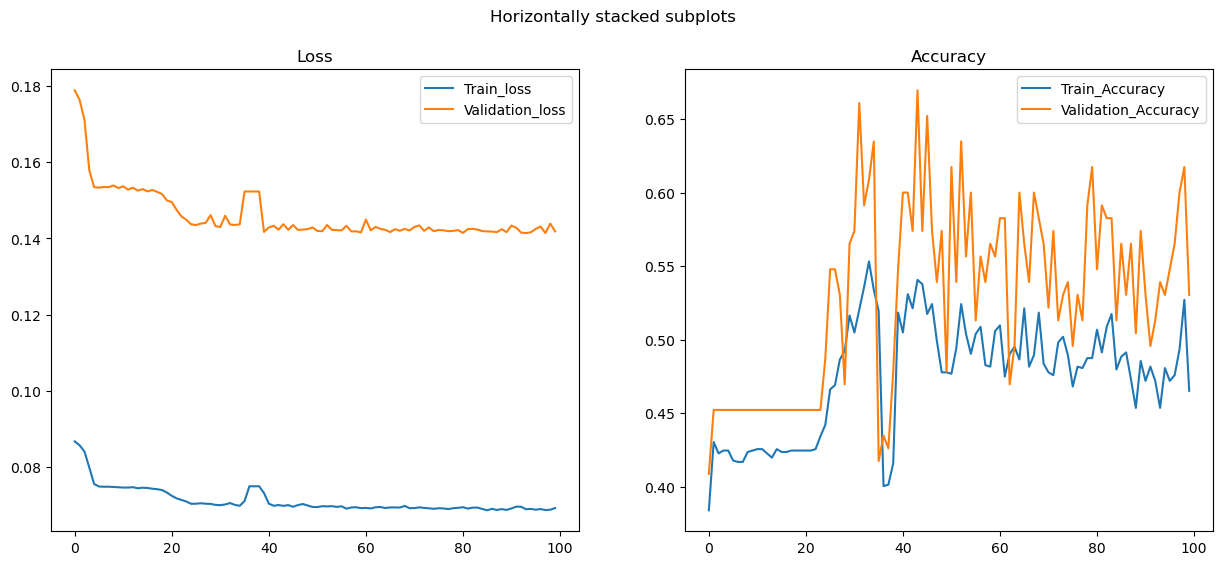

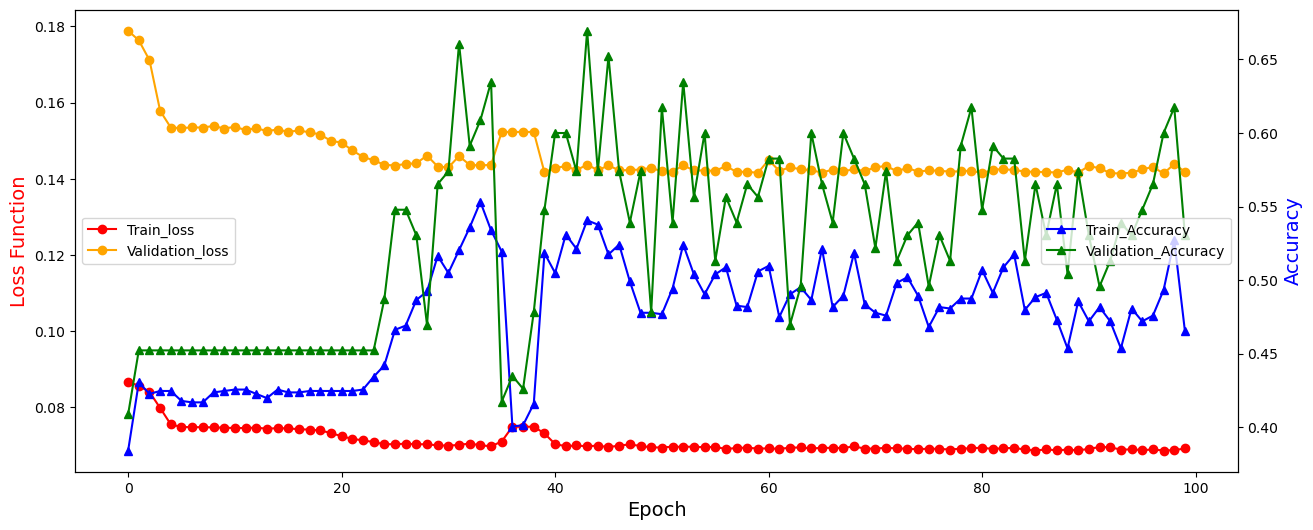

Current time: 31.509 minutes. Time expected till completion: 126.036 minutes

Epoch 101 of 500


100%|██████████| 15/15 [00:00<00:00, 16.84it/s]


train loss:  0.06860944311669533
Val loss:  0.14161965536034626
train accuracy:  0.5077369439071566
Val accuracy:  0.5652173913043478
Current time: 31.814 minutes. Time expected till completion: 125.683 minutes

Epoch 102 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.06863243632897648
Val loss:  0.1410759749619857
train accuracy:  0.45454545454545453
Val accuracy:  0.5478260869565217
Current time: 32.124 minutes. Time expected till completion: 125.345 minutes

Epoch 103 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.06888122484808504
Val loss:  0.14216664666714876
train accuracy:  0.47775628626692457
Val accuracy:  0.5130434782608696
Current time: 32.432 minutes. Time expected till completion: 125.004 minutes

Epoch 104 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.06871776533541873
Val loss:  0.14121820615685504
train accuracy:  0.4864603481624758
Val accuracy:  0.5565217391304348
Current time: 32.741 minutes. Time expected till completion: 124.667 minutes

Epoch 105 of 500


100%|██████████| 15/15 [00:00<00:00, 16.53it/s]


train loss:  0.06856788674682898
Val loss:  0.14265041921449745
train accuracy:  0.47678916827852996
Val accuracy:  0.5478260869565217
Current time: 33.050 minutes. Time expected till completion: 124.332 minutes

Epoch 106 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.06828646906570493
Val loss:  0.14260704206383745
train accuracy:  0.47292069632495165
Val accuracy:  0.5565217391304348
Current time: 33.361 minutes. Time expected till completion: 124.002 minutes

Epoch 107 of 500


100%|██████████| 15/15 [00:00<00:00, 16.10it/s]


train loss:  0.06869843584887064
Val loss:  0.14250036322552226
train accuracy:  0.46518375241779497
Val accuracy:  0.6086956521739131
Current time: 33.671 minutes. Time expected till completion: 123.671 minutes

Epoch 108 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.06857355547135757
Val loss:  0.14105207609093706
train accuracy:  0.5425531914893617
Val accuracy:  0.5739130434782609
Current time: 33.983 minutes. Time expected till completion: 123.344 minutes

Epoch 109 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.06838539663550933
Val loss:  0.14162821925204733
train accuracy:  0.4787234042553192
Val accuracy:  0.5565217391304348
Current time: 34.290 minutes. Time expected till completion: 123.005 minutes

Epoch 110 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.06865863925714327
Val loss:  0.14110306397728298
train accuracy:  0.4835589941972921
Val accuracy:  0.5391304347826087
Current time: 34.599 minutes. Time expected till completion: 122.670 minutes

Epoch 111 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.06866110547137676
Val loss:  0.14137356695921524
train accuracy:  0.47292069632495165
Val accuracy:  0.4956521739130435
Current time: 34.908 minutes. Time expected till completion: 122.336 minutes

Epoch 112 of 500


100%|██████████| 15/15 [00:00<00:00, 16.55it/s]


train loss:  0.06855914884425224
Val loss:  0.14137934860975845
train accuracy:  0.4816247582205029
Val accuracy:  0.5565217391304348
Current time: 35.218 minutes. Time expected till completion: 122.004 minutes

Epoch 113 of 500


100%|██████████| 15/15 [00:00<00:00, 16.22it/s]


train loss:  0.06847422565666804
Val loss:  0.14222399410994158
train accuracy:  0.48936170212765956
Val accuracy:  0.4782608695652174
Current time: 35.527 minutes. Time expected till completion: 121.672 minutes

Epoch 114 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.06890740414191492
Val loss:  0.14104203348574432
train accuracy:  0.4874274661508704
Val accuracy:  0.5478260869565217
Current time: 35.839 minutes. Time expected till completion: 121.351 minutes

Epoch 115 of 500


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


train loss:  0.06838186526206291
Val loss:  0.1411123400149138
train accuracy:  0.5193423597678917
Val accuracy:  0.5652173913043478
Current time: 36.149 minutes. Time expected till completion: 121.021 minutes

Epoch 116 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.06812662024562548
Val loss:  0.14323960283528203
train accuracy:  0.5145067698259188
Val accuracy:  0.5043478260869565
Current time: 36.459 minutes. Time expected till completion: 120.690 minutes

Epoch 117 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.06860378609404573
Val loss:  0.14125185997589776
train accuracy:  0.528046421663443
Val accuracy:  0.5826086956521739
Current time: 36.770 minutes. Time expected till completion: 120.368 minutes

Epoch 118 of 500


100%|██████████| 15/15 [00:00<00:00, 16.37it/s]


train loss:  0.06861186684676711
Val loss:  0.14144224083941917
train accuracy:  0.5531914893617021
Val accuracy:  0.5652173913043478
Current time: 37.085 minutes. Time expected till completion: 120.055 minutes

Epoch 119 of 500


100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


train loss:  0.06860336793921672
Val loss:  0.1411496245342752
train accuracy:  0.5299806576402321
Val accuracy:  0.5652173913043478
Current time: 37.397 minutes. Time expected till completion: 119.733 minutes

Epoch 120 of 500


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


train loss:  0.06869390837459084
Val loss:  0.14106243641480157
train accuracy:  0.4825918762088975
Val accuracy:  0.5391304347826087
Current time: 37.709 minutes. Time expected till completion: 119.412 minutes

Epoch 121 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.06856034064892413
Val loss:  0.14133766630421515
train accuracy:  0.48452611218568664
Val accuracy:  0.5565217391304348
Current time: 38.022 minutes. Time expected till completion: 119.092 minutes

Epoch 122 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.0682320586140889
Val loss:  0.14159245180047075
train accuracy:  0.5183752417794971
Val accuracy:  0.6
Current time: 38.332 minutes. Time expected till completion: 118.766 minutes

Epoch 123 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.0682499790906445
Val loss:  0.14485401796258013
train accuracy:  0.5106382978723404
Val accuracy:  0.6260869565217392
Current time: 38.643 minutes. Time expected till completion: 118.444 minutes

Epoch 124 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.06868992910163776
Val loss:  0.14169368121934975
train accuracy:  0.5647969052224371
Val accuracy:  0.4956521739130435
Current time: 38.953 minutes. Time expected till completion: 118.115 minutes

Epoch 125 of 500


100%|██████████| 15/15 [00:00<00:00, 16.22it/s]


train loss:  0.06857202517686545
Val loss:  0.14299058447713436
train accuracy:  0.574468085106383
Val accuracy:  0.591304347826087
Current time: 39.265 minutes. Time expected till completion: 117.794 minutes

Epoch 126 of 500


100%|██████████| 15/15 [00:00<00:00, 16.46it/s]


train loss:  0.06853946242157219
Val loss:  0.1420265555381775
train accuracy:  0.5125725338491296
Val accuracy:  0.5826086956521739
Current time: 39.575 minutes. Time expected till completion: 117.469 minutes

Epoch 127 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.06867053251663076
Val loss:  0.14208700708720995
train accuracy:  0.5425531914893617
Val accuracy:  0.5565217391304348
Current time: 39.885 minutes. Time expected till completion: 117.143 minutes

Epoch 128 of 500


100%|██████████| 15/15 [00:00<00:00, 16.45it/s]


train loss:  0.06837853420403295
Val loss:  0.14154604725215747
train accuracy:  0.534816247582205
Val accuracy:  0.5478260869565217
Current time: 40.197 minutes. Time expected till completion: 116.822 minutes

Epoch 129 of 500


100%|██████████| 15/15 [00:00<00:00, 16.58it/s]


train loss:  0.06804318809647625
Val loss:  0.14023429103519605
train accuracy:  0.5328820116054158
Val accuracy:  0.5739130434782609
Current time: 40.506 minutes. Time expected till completion: 116.493 minutes

Epoch 130 of 500


100%|██████████| 15/15 [00:00<00:00, 16.75it/s]


train loss:  0.06825705526875804
Val loss:  0.14060703878817352
train accuracy:  0.534816247582205
Val accuracy:  0.6
Current time: 40.813 minutes. Time expected till completion: 116.161 minutes

Epoch 131 of 500


100%|██████████| 15/15 [00:00<00:00, 16.05it/s]


train loss:  0.06835504530476878
Val loss:  0.14052271013674528
train accuracy:  0.5570599613152805
Val accuracy:  0.5826086956521739
Current time: 41.125 minutes. Time expected till completion: 115.842 minutes

Epoch 132 of 500


100%|██████████| 15/15 [00:00<00:00, 16.58it/s]


train loss:  0.06834499304483661
Val loss:  0.14148496389389037
train accuracy:  0.5454545454545454
Val accuracy:  0.5391304347826087
Current time: 41.435 minutes. Time expected till completion: 115.517 minutes

Epoch 133 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.06829212839414349
Val loss:  0.1406472465266352
train accuracy:  0.5203094777562862
Val accuracy:  0.5478260869565217
Current time: 41.746 minutes. Time expected till completion: 115.194 minutes

Epoch 134 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.06803638774836779
Val loss:  0.14150020713391512
train accuracy:  0.5338491295938105
Val accuracy:  0.5304347826086957
Current time: 42.057 minutes. Time expected till completion: 114.871 minutes

Epoch 135 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.06844443290330456
Val loss:  0.14086083743883215
train accuracy:  0.5299806576402321
Val accuracy:  0.591304347826087
Current time: 42.367 minutes. Time expected till completion: 114.547 minutes

Epoch 136 of 500


100%|██████████| 15/15 [00:00<00:00, 16.56it/s]


train loss:  0.06834110825158642
Val loss:  0.1406212894812874
train accuracy:  0.5483558994197292
Val accuracy:  0.591304347826087
Current time: 42.676 minutes. Time expected till completion: 114.220 minutes

Epoch 137 of 500


100%|██████████| 15/15 [00:00<00:00, 16.05it/s]


train loss:  0.06866799505351821
Val loss:  0.14064703246821528
train accuracy:  0.5357833655705996
Val accuracy:  0.5652173913043478
Current time: 42.986 minutes. Time expected till completion: 113.898 minutes

Epoch 138 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.06865695170784365
Val loss:  0.14116701716962068
train accuracy:  0.5193423597678917
Val accuracy:  0.5217391304347826
Current time: 43.296 minutes. Time expected till completion: 113.574 minutes

Epoch 139 of 500


100%|██████████| 15/15 [00:00<00:00, 16.45it/s]


train loss:  0.06823917819867974
Val loss:  0.14095831850300664
train accuracy:  0.5077369439071566
Val accuracy:  0.5826086956521739
Current time: 43.604 minutes. Time expected till completion: 113.245 minutes

Epoch 140 of 500


100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


train loss:  0.06820027002744103
Val loss:  0.14175417267757914
train accuracy:  0.5212765957446809
Val accuracy:  0.5391304347826087
Current time: 43.914 minutes. Time expected till completion: 112.922 minutes

Epoch 141 of 500


100%|██████████| 15/15 [00:00<00:00, 16.56it/s]


train loss:  0.06840809136340881
Val loss:  0.1415875149809796
train accuracy:  0.539651837524178
Val accuracy:  0.5739130434782609
Current time: 44.223 minutes. Time expected till completion: 112.596 minutes

Epoch 142 of 500


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


train loss:  0.0684024409699025
Val loss:  0.14078439836916717
train accuracy:  0.52321083172147
Val accuracy:  0.5739130434782609
Current time: 44.534 minutes. Time expected till completion: 112.275 minutes

Epoch 143 of 500


100%|██████████| 15/15 [00:00<00:00, 16.55it/s]


train loss:  0.06820686925310691
Val loss:  0.1413256945817367
train accuracy:  0.5386847195357833
Val accuracy:  0.5304347826086957
Current time: 44.843 minutes. Time expected till completion: 111.951 minutes

Epoch 144 of 500


100%|██████████| 15/15 [00:00<00:00, 16.28it/s]


train loss:  0.06845846432090036
Val loss:  0.14037196428879448
train accuracy:  0.5473887814313346
Val accuracy:  0.5826086956521739
Current time: 45.152 minutes. Time expected till completion: 111.625 minutes

Epoch 145 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.06822623528641013
Val loss:  0.14067957764086517
train accuracy:  0.5174081237911026
Val accuracy:  0.5391304347826087
Current time: 45.461 minutes. Time expected till completion: 111.301 minutes

Epoch 146 of 500


100%|██████████| 15/15 [00:00<00:00, 15.83it/s]


train loss:  0.06827264349741909
Val loss:  0.14198402114536451
train accuracy:  0.5154738878143134
Val accuracy:  0.4956521739130435
Current time: 45.773 minutes. Time expected till completion: 110.985 minutes

Epoch 147 of 500


100%|██████████| 15/15 [00:00<00:00, 16.88it/s]


train loss:  0.06847013806927826
Val loss:  0.141367186670718
train accuracy:  0.558027079303675
Val accuracy:  0.5478260869565217
Current time: 46.083 minutes. Time expected till completion: 110.661 minutes

Epoch 148 of 500


100%|██████████| 15/15 [00:00<00:00, 16.49it/s]


train loss:  0.06825703866707748
Val loss:  0.14115748249966165
train accuracy:  0.539651837524178
Val accuracy:  0.5217391304347826
Current time: 46.393 minutes. Time expected till completion: 110.340 minutes

Epoch 149 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.06790371616758277
Val loss:  0.14142258633737978
train accuracy:  0.4874274661508704
Val accuracy:  0.6086956521739131
Current time: 46.704 minutes. Time expected till completion: 110.020 minutes

Epoch 150 of 500


100%|██████████| 15/15 [00:00<00:00, 16.22it/s]


train loss:  0.06848247847889101
Val loss:  0.1412412633066592
train accuracy:  0.528046421663443
Val accuracy:  0.591304347826087
Current time: 47.013 minutes. Time expected till completion: 109.698 minutes

Epoch 151 of 500


100%|██████████| 15/15 [00:00<00:00, 16.77it/s]


train loss:  0.06840058008291736
Val loss:  0.141513380797013
train accuracy:  0.5502901353965184
Val accuracy:  0.5739130434782609
Current time: 47.321 minutes. Time expected till completion: 109.371 minutes

Epoch 152 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.0680258178388127
Val loss:  0.14063370590624602
train accuracy:  0.5454545454545454
Val accuracy:  0.6086956521739131
Current time: 47.628 minutes. Time expected till completion: 109.043 minutes

Epoch 153 of 500


100%|██████████| 15/15 [00:00<00:00, 16.60it/s]


train loss:  0.06819104514223465
Val loss:  0.14004103619119396
train accuracy:  0.5560928433268859
Val accuracy:  0.5478260869565217
Current time: 47.936 minutes. Time expected till completion: 108.719 minutes

Epoch 154 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.06861692707358753
Val loss:  0.14067682027816772
train accuracy:  0.4932301740812379
Val accuracy:  0.5391304347826087
Current time: 48.245 minutes. Time expected till completion: 108.394 minutes

Epoch 155 of 500


100%|██████████| 15/15 [00:00<00:00, 16.28it/s]


train loss:  0.06841255421795282
Val loss:  0.1406405272691146
train accuracy:  0.5164410058027079
Val accuracy:  0.5565217391304348
Current time: 48.554 minutes. Time expected till completion: 108.071 minutes

Epoch 156 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.06811334253279798
Val loss:  0.14182893970738286
train accuracy:  0.5309477756286267
Val accuracy:  0.5391304347826087
Current time: 48.863 minutes. Time expected till completion: 107.749 minutes

Epoch 157 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.06837917769208868
Val loss:  0.14107038922931836
train accuracy:  0.5125725338491296
Val accuracy:  0.5652173913043478
Current time: 49.174 minutes. Time expected till completion: 107.431 minutes

Epoch 158 of 500


100%|██████████| 15/15 [00:00<00:00, 16.53it/s]


train loss:  0.06806313438157278
Val loss:  0.1408459678940151
train accuracy:  0.5415860735009671
Val accuracy:  0.5304347826086957
Current time: 49.485 minutes. Time expected till completion: 107.113 minutes

Epoch 159 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.06804515141813622
Val loss:  0.13961749284163766
train accuracy:  0.48936170212765956
Val accuracy:  0.5043478260869565
Current time: 49.797 minutes. Time expected till completion: 106.798 minutes

Epoch 160 of 500


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


train loss:  0.06881129470738498
Val loss:  0.1414617403693821
train accuracy:  0.5270793036750484
Val accuracy:  0.6260869565217392
Current time: 50.110 minutes. Time expected till completion: 106.484 minutes

Epoch 161 of 500


100%|██████████| 15/15 [00:00<00:00, 16.22it/s]


train loss:  0.06802893123036427
Val loss:  0.1412840698076331
train accuracy:  0.5203094777562862
Val accuracy:  0.5478260869565217
Current time: 50.422 minutes. Time expected till completion: 106.168 minutes

Epoch 162 of 500


100%|██████████| 15/15 [00:00<00:00, 15.44it/s]


train loss:  0.06805888458192925
Val loss:  0.14001602504564367
train accuracy:  0.5270793036750484
Val accuracy:  0.5043478260869565
Current time: 50.736 minutes. Time expected till completion: 105.856 minutes

Epoch 163 of 500


100%|██████████| 15/15 [00:00<00:00, 16.10it/s]


train loss:  0.06802162545331442
Val loss:  0.13985834691835486
train accuracy:  0.5019342359767892
Val accuracy:  0.5391304347826087
Current time: 51.055 minutes. Time expected till completion: 105.555 minutes

Epoch 164 of 500


100%|██████████| 15/15 [00:00<00:00, 16.12it/s]


train loss:  0.06777855384972387
Val loss:  0.1406164464743241
train accuracy:  0.5154738878143134
Val accuracy:  0.6
Current time: 51.407 minutes. Time expected till completion: 105.322 minutes

Epoch 165 of 500


100%|██████████| 15/15 [00:00<00:00, 15.07it/s]


train loss:  0.0679805009000767
Val loss:  0.14031357454216997
train accuracy:  0.5251450676982592
Val accuracy:  0.5565217391304348
Current time: 51.758 minutes. Time expected till completion: 105.085 minutes

Epoch 166 of 500


100%|██████████| 15/15 [00:00<00:00, 15.15it/s]


train loss:  0.06787441731421583
Val loss:  0.14043695356534874
train accuracy:  0.5464216634429401
Val accuracy:  0.6086956521739131
Current time: 52.175 minutes. Time expected till completion: 104.978 minutes

Epoch 167 of 500


100%|██████████| 15/15 [00:00<00:00, 15.44it/s]


train loss:  0.06805177133825807
Val loss:  0.14233292289402175
train accuracy:  0.5425531914893617
Val accuracy:  0.6347826086956522
Current time: 52.535 minutes. Time expected till completion: 104.756 minutes

Epoch 168 of 500


100%|██████████| 15/15 [00:00<00:00, 15.10it/s]


train loss:  0.06807318093467728
Val loss:  0.1407399726950604
train accuracy:  0.5512572533849129
Val accuracy:  0.5652173913043478
Current time: 52.901 minutes. Time expected till completion: 104.543 minutes

Epoch 169 of 500


100%|██████████| 15/15 [00:00<00:00, 15.19it/s]


train loss:  0.06848854500966099
Val loss:  0.14086503827053568
train accuracy:  0.5541586073500967
Val accuracy:  0.5217391304347826
Current time: 53.281 minutes. Time expected till completion: 104.356 minutes

Epoch 170 of 500


100%|██████████| 15/15 [00:00<00:00, 15.03it/s]


train loss:  0.06790896500794062
Val loss:  0.14067504976106726
train accuracy:  0.5425531914893617
Val accuracy:  0.5304347826086957
Current time: 53.653 minutes. Time expected till completion: 104.149 minutes

Epoch 171 of 500


100%|██████████| 15/15 [00:00<00:00, 15.46it/s]


train loss:  0.06802712568231431
Val loss:  0.14056262814480325
train accuracy:  0.5406189555125726
Val accuracy:  0.6086956521739131
Current time: 54.027 minutes. Time expected till completion: 103.946 minutes

Epoch 172 of 500


100%|██████████| 15/15 [00:00<00:00, 15.49it/s]


train loss:  0.0681357459242616
Val loss:  0.14065861442814703
train accuracy:  0.5464216634429401
Val accuracy:  0.5478260869565217
Current time: 54.391 minutes. Time expected till completion: 103.722 minutes

Epoch 173 of 500


100%|██████████| 15/15 [00:01<00:00, 14.94it/s]


train loss:  0.06816771320955435
Val loss:  0.14148266315460206
train accuracy:  0.5222437137330754
Val accuracy:  0.591304347826087
Current time: 54.762 minutes. Time expected till completion: 103.510 minutes

Epoch 174 of 500


100%|██████████| 15/15 [00:00<00:00, 15.35it/s]


train loss:  0.06779350706410361
Val loss:  0.14049244497133337
train accuracy:  0.5493230174081238
Val accuracy:  0.6260869565217392
Current time: 55.125 minutes. Time expected till completion: 103.280 minutes

Epoch 175 of 500


100%|██████████| 15/15 [00:00<00:00, 15.46it/s]


train loss:  0.06833543076505974
Val loss:  0.14032709235730378
train accuracy:  0.5551257253384912
Val accuracy:  0.6521739130434783
Current time: 55.489 minutes. Time expected till completion: 103.051 minutes

Epoch 176 of 500


100%|██████████| 15/15 [00:00<00:00, 15.16it/s]


train loss:  0.06830708564365394
Val loss:  0.14110344233720198
train accuracy:  0.5444874274661509
Val accuracy:  0.5652173913043478
Current time: 55.850 minutes. Time expected till completion: 102.815 minutes

Epoch 177 of 500


100%|██████████| 15/15 [00:00<00:00, 15.67it/s]


train loss:  0.06787389920343513
Val loss:  0.13999832661255546
train accuracy:  0.5319148936170213
Val accuracy:  0.5565217391304348
Current time: 56.213 minutes. Time expected till completion: 102.580 minutes

Epoch 178 of 500


100%|██████████| 15/15 [00:00<00:00, 15.33it/s]


train loss:  0.06815325568215759
Val loss:  0.13996782199196192
train accuracy:  0.5290135396518375
Val accuracy:  0.6521739130434783
Current time: 56.574 minutes. Time expected till completion: 102.342 minutes

Epoch 179 of 500


100%|██████████| 15/15 [00:00<00:00, 15.88it/s]


train loss:  0.0680261528699495
Val loss:  0.14156381513761437
train accuracy:  0.5493230174081238
Val accuracy:  0.6434782608695652
Current time: 56.907 minutes. Time expected till completion: 102.050 minutes

Epoch 180 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.06778210326596892
Val loss:  0.13947400010150413
train accuracy:  0.5541586073500967
Val accuracy:  0.5826086956521739
Current time: 57.231 minutes. Time expected till completion: 101.744 minutes

Epoch 181 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.06790434195870818
Val loss:  0.14134320331656414
train accuracy:  0.5444874274661509
Val accuracy:  0.6173913043478261
Current time: 57.552 minutes. Time expected till completion: 101.432 minutes

Epoch 182 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.06805643998446732
Val loss:  0.1398521734320599
train accuracy:  0.5222437137330754
Val accuracy:  0.5217391304347826
Current time: 57.875 minutes. Time expected till completion: 101.122 minutes

Epoch 183 of 500


100%|██████████| 15/15 [00:00<00:00, 15.77it/s]


train loss:  0.06815233215603192
Val loss:  0.14082344096639882
train accuracy:  0.5058027079303675
Val accuracy:  0.6086956521739131
Current time: 58.197 minutes. Time expected till completion: 100.812 minutes

Epoch 184 of 500


100%|██████████| 15/15 [00:00<00:00, 16.10it/s]


train loss:  0.06822656126732522
Val loss:  0.14038853438004203
train accuracy:  0.5551257253384912
Val accuracy:  0.6434782608695652
Current time: 58.519 minutes. Time expected till completion: 100.500 minutes

Epoch 185 of 500


100%|██████████| 15/15 [00:00<00:00, 16.17it/s]


train loss:  0.06765763210835263
Val loss:  0.14039666341698687
train accuracy:  0.5541586073500967
Val accuracy:  0.6260869565217392
Current time: 58.840 minutes. Time expected till completion: 100.186 minutes

Epoch 186 of 500


100%|██████████| 15/15 [00:00<00:00, 16.21it/s]


train loss:  0.0680542992323464
Val loss:  0.14083760199339493
train accuracy:  0.5541586073500967
Val accuracy:  0.591304347826087
Current time: 59.163 minutes. Time expected till completion: 99.877 minutes

Epoch 187 of 500


100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


train loss:  0.06805995567854876
Val loss:  0.13995383200438127
train accuracy:  0.5822050290135397
Val accuracy:  0.6521739130434783
Current time: 59.483 minutes. Time expected till completion: 99.563 minutes

Epoch 188 of 500


100%|██████████| 15/15 [00:00<00:00, 15.65it/s]


train loss:  0.067938979924071
Val loss:  0.14353039523829583
train accuracy:  0.5435203094777563
Val accuracy:  0.6434782608695652
Current time: 59.809 minutes. Time expected till completion: 99.257 minutes

Epoch 189 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.06780162707288215
Val loss:  0.1406340645707172
train accuracy:  0.562862669245648
Val accuracy:  0.6434782608695652
Current time: 60.131 minutes. Time expected till completion: 98.946 minutes

Epoch 190 of 500


100%|██████████| 15/15 [00:00<00:00, 15.87it/s]


train loss:  0.06778730397298212
Val loss:  0.14158055937808492
train accuracy:  0.5551257253384912
Val accuracy:  0.591304347826087
Current time: 60.453 minutes. Time expected till completion: 98.633 minutes

Epoch 191 of 500


100%|██████████| 15/15 [00:00<00:00, 16.17it/s]


train loss:  0.06768319339309485
Val loss:  0.13920510385347448
train accuracy:  0.5551257253384912
Val accuracy:  0.6260869565217392
Current time: 60.773 minutes. Time expected till completion: 98.318 minutes

Epoch 192 of 500


100%|██████████| 15/15 [00:00<00:00, 15.62it/s]


train loss:  0.06814738860213318
Val loss:  0.14005873825239099
train accuracy:  0.5570599613152805
Val accuracy:  0.6173913043478261
Current time: 61.101 minutes. Time expected till completion: 98.016 minutes

Epoch 193 of 500


100%|██████████| 15/15 [00:00<00:00, 15.90it/s]


train loss:  0.06783510793569701
Val loss:  0.13923215088636978
train accuracy:  0.539651837524178
Val accuracy:  0.6347826086956522
Current time: 61.424 minutes. Time expected till completion: 97.705 minutes

Epoch 194 of 500


100%|██████████| 15/15 [00:00<00:00, 16.21it/s]


train loss:  0.06814991315282752
Val loss:  0.1399717040683912
train accuracy:  0.5483558994197292
Val accuracy:  0.6173913043478261
Current time: 61.745 minutes. Time expected till completion: 97.392 minutes

Epoch 195 of 500


100%|██████████| 15/15 [00:00<00:00, 16.02it/s]


train loss:  0.06785461986779706
Val loss:  0.14457030555476313
train accuracy:  0.5444874274661509
Val accuracy:  0.6260869565217392
Current time: 62.065 minutes. Time expected till completion: 97.076 minutes

Epoch 196 of 500


100%|██████████| 15/15 [00:00<00:00, 16.12it/s]


train loss:  0.06763895170139851
Val loss:  0.13966865695041158
train accuracy:  0.5560928433268859
Val accuracy:  0.6260869565217392
Current time: 62.387 minutes. Time expected till completion: 96.764 minutes

Epoch 197 of 500


100%|██████████| 15/15 [00:00<00:00, 15.54it/s]


train loss:  0.06772231865436473
Val loss:  0.13916938875032508
train accuracy:  0.5686653771760155
Val accuracy:  0.6608695652173913
Current time: 62.711 minutes. Time expected till completion: 96.454 minutes

Epoch 198 of 500


100%|██████████| 15/15 [00:00<00:00, 15.83it/s]


train loss:  0.06783963932981804
Val loss:  0.14006175528401915
train accuracy:  0.5261121856866537
Val accuracy:  0.6521739130434783
Current time: 63.051 minutes. Time expected till completion: 96.169 minutes

Epoch 199 of 500


100%|██████████| 15/15 [00:00<00:00, 15.90it/s]


train loss:  0.06798159972380854
Val loss:  0.14007338285446166
train accuracy:  0.5367504835589942
Val accuracy:  0.6434782608695652
Current time: 63.378 minutes. Time expected till completion: 95.862 minutes

Epoch 200 of 500


100%|██████████| 15/15 [00:00<00:00, 15.83it/s]


train loss:  0.06778068047888736
Val loss:  0.1393720030784607
train accuracy:  0.539651837524178
Val accuracy:  0.5652173913043478
Saving model checkpoint


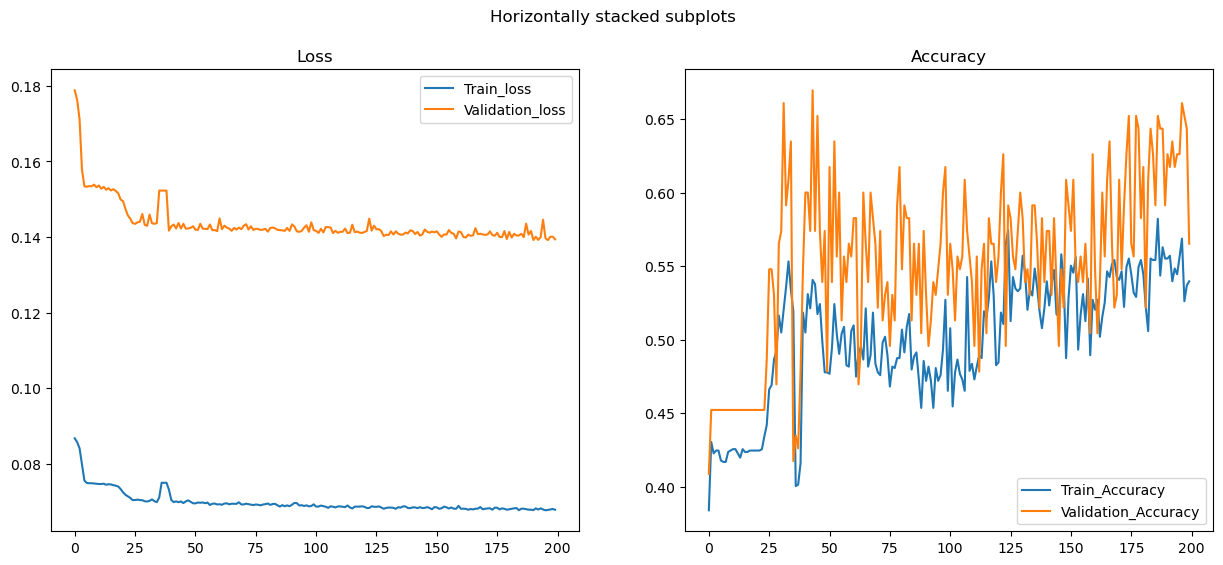

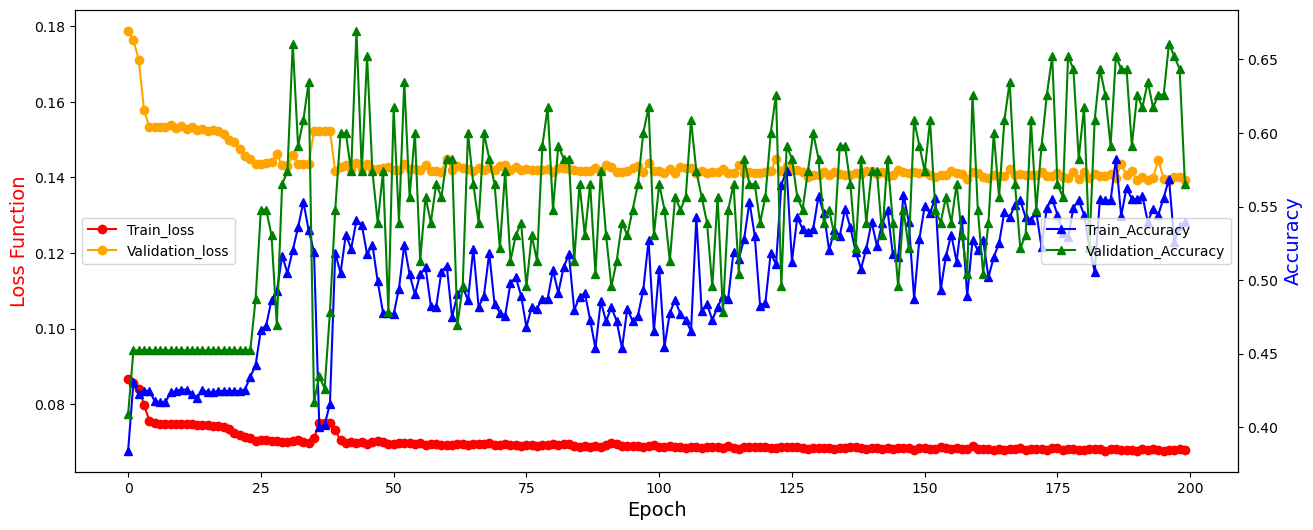

Current time: 63.725 minutes. Time expected till completion: 95.588 minutes

Epoch 201 of 500


100%|██████████| 15/15 [00:00<00:00, 15.06it/s]


train loss:  0.06792495657673657
Val loss:  0.1411775625270346
train accuracy:  0.5464216634429401
Val accuracy:  0.5826086956521739
Current time: 64.062 minutes. Time expected till completion: 95.296 minutes

Epoch 202 of 500


100%|██████████| 15/15 [00:00<00:00, 15.83it/s]


train loss:  0.06787253763505062
Val loss:  0.14046982785929804
train accuracy:  0.5909090909090909
Val accuracy:  0.6521739130434783
Current time: 64.399 minutes. Time expected till completion: 95.004 minutes

Epoch 203 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.06803687127231399
Val loss:  0.1404700844184212
train accuracy:  0.5367504835589942
Val accuracy:  0.6260869565217392
Current time: 64.727 minutes. Time expected till completion: 94.698 minutes

Epoch 204 of 500


100%|██████████| 15/15 [00:00<00:00, 15.51it/s]


train loss:  0.06793240865609632
Val loss:  0.13912631843401038
train accuracy:  0.5589941972920697
Val accuracy:  0.6434782608695652
Current time: 65.056 minutes. Time expected till completion: 94.395 minutes

Epoch 205 of 500


100%|██████████| 15/15 [00:00<00:00, 15.65it/s]


train loss:  0.0679439525309107
Val loss:  0.14069046611371247
train accuracy:  0.534816247582205
Val accuracy:  0.6173913043478261
Current time: 65.377 minutes. Time expected till completion: 94.080 minutes

Epoch 206 of 500


100%|██████████| 15/15 [00:00<00:00, 15.73it/s]


train loss:  0.06796711446929947
Val loss:  0.14042459622673367
train accuracy:  0.5319148936170213
Val accuracy:  0.5826086956521739
Current time: 65.710 minutes. Time expected till completion: 93.780 minutes

Epoch 207 of 500


100%|██████████| 15/15 [00:00<00:00, 15.93it/s]


train loss:  0.06748501838291175
Val loss:  0.14129136386124985
train accuracy:  0.5406189555125726
Val accuracy:  0.5652173913043478
Current time: 66.042 minutes. Time expected till completion: 93.480 minutes

Epoch 208 of 500


100%|██████████| 15/15 [00:00<00:00, 15.90it/s]


train loss:  0.06751458418899625
Val loss:  0.14094721700834192
train accuracy:  0.534816247582205
Val accuracy:  0.6173913043478261
Current time: 66.370 minutes. Time expected till completion: 93.173 minutes

Epoch 209 of 500


100%|██████████| 15/15 [00:00<00:00, 15.27it/s]


train loss:  0.06768707178778068
Val loss:  0.14040708075398983
train accuracy:  0.5512572533849129
Val accuracy:  0.6086956521739131
Current time: 66.699 minutes. Time expected till completion: 92.868 minutes

Epoch 210 of 500


100%|██████████| 15/15 [00:00<00:00, 15.77it/s]


train loss:  0.06768912549636812
Val loss:  0.14059480480525804
train accuracy:  0.562862669245648
Val accuracy:  0.6434782608695652
Current time: 67.030 minutes. Time expected till completion: 92.566 minutes

Epoch 211 of 500


100%|██████████| 15/15 [00:00<00:00, 15.62it/s]


train loss:  0.0675645564580102
Val loss:  0.13873102042986
train accuracy:  0.5512572533849129
Val accuracy:  0.6260869565217392
Current time: 67.354 minutes. Time expected till completion: 92.252 minutes

Epoch 212 of 500


100%|██████████| 15/15 [00:00<00:00, 15.59it/s]


train loss:  0.0676812055147824
Val loss:  0.1402275386063949
train accuracy:  0.539651837524178
Val accuracy:  0.6434782608695652
Current time: 67.682 minutes. Time expected till completion: 91.945 minutes

Epoch 213 of 500


100%|██████████| 15/15 [00:00<00:00, 15.54it/s]


train loss:  0.06800601895127582
Val loss:  0.13953321550203407
train accuracy:  0.5599613152804642
Val accuracy:  0.6086956521739131
Current time: 68.011 minutes. Time expected till completion: 91.639 minutes

Epoch 214 of 500


100%|██████████| 15/15 [00:00<00:00, 15.07it/s]


train loss:  0.06772293159071666
Val loss:  0.14023322903591653
train accuracy:  0.5444874274661509
Val accuracy:  0.6347826086956522
Current time: 68.347 minutes. Time expected till completion: 91.342 minutes

Epoch 215 of 500


100%|██████████| 15/15 [00:00<00:00, 16.05it/s]


train loss:  0.06751123186006307
Val loss:  0.14033233445623647
train accuracy:  0.5512572533849129
Val accuracy:  0.591304347826087
Current time: 68.672 minutes. Time expected till completion: 91.030 minutes

Epoch 216 of 500


100%|██████████| 15/15 [00:00<00:00, 15.85it/s]


train loss:  0.06773242360157478
Val loss:  0.14110637436742368
train accuracy:  0.5735009671179884
Val accuracy:  0.6173913043478261
Current time: 68.996 minutes. Time expected till completion: 90.717 minutes

Epoch 217 of 500


100%|██████████| 15/15 [00:00<00:00, 15.88it/s]


train loss:  0.06767924674705564
Val loss:  0.1382464533266814
train accuracy:  0.5502901353965184
Val accuracy:  0.6695652173913044
Current time: 69.318 minutes. Time expected till completion: 90.401 minutes

Epoch 218 of 500


100%|██████████| 15/15 [00:00<00:00, 15.44it/s]


train loss:  0.06772009547028827
Val loss:  0.14106274273084557
train accuracy:  0.5696324951644101
Val accuracy:  0.6
Current time: 69.641 minutes. Time expected till completion: 90.086 minutes

Epoch 219 of 500


100%|██████████| 15/15 [00:00<00:00, 16.00it/s]


train loss:  0.06762728181521713
Val loss:  0.14161495955094047
train accuracy:  0.5464216634429401
Val accuracy:  0.5826086956521739
Current time: 69.982 minutes. Time expected till completion: 89.794 minutes

Epoch 220 of 500


100%|██████████| 15/15 [00:00<00:00, 16.00it/s]


train loss:  0.0678542519791675
Val loss:  0.13922860881556634
train accuracy:  0.5512572533849129
Val accuracy:  0.6434782608695652
Current time: 70.304 minutes. Time expected till completion: 89.478 minutes

Epoch 221 of 500


100%|██████████| 15/15 [00:00<00:00, 16.05it/s]


train loss:  0.06796521709320393
Val loss:  0.1407933286998583
train accuracy:  0.5735009671179884
Val accuracy:  0.6434782608695652
Current time: 70.628 minutes. Time expected till completion: 89.163 minutes

Epoch 222 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.06779601726126164
Val loss:  0.14035968210386193
train accuracy:  0.5947775628626693
Val accuracy:  0.6347826086956522
Current time: 70.953 minutes. Time expected till completion: 88.851 minutes

Epoch 223 of 500


100%|██████████| 15/15 [00:00<00:00, 15.43it/s]


train loss:  0.06773599792034068
Val loss:  0.1423402470091115
train accuracy:  0.5531914893617021
Val accuracy:  0.591304347826087
Current time: 71.281 minutes. Time expected till completion: 88.542 minutes

Epoch 224 of 500


100%|██████████| 15/15 [00:00<00:00, 16.05it/s]


train loss:  0.06762760618207994
Val loss:  0.14040539679319963
train accuracy:  0.528046421663443
Val accuracy:  0.6260869565217392
Current time: 71.604 minutes. Time expected till completion: 88.226 minutes

Epoch 225 of 500


100%|██████████| 15/15 [00:00<00:00, 15.82it/s]


train loss:  0.06758967278312668
Val loss:  0.14102453097053197
train accuracy:  0.5676982591876208
Val accuracy:  0.6173913043478261
Current time: 71.928 minutes. Time expected till completion: 87.911 minutes

Epoch 226 of 500


100%|██████████| 15/15 [00:00<00:00, 16.10it/s]


train loss:  0.06750257356485038
Val loss:  0.13966845792272817
train accuracy:  0.5493230174081238
Val accuracy:  0.6434782608695652
Current time: 72.251 minutes. Time expected till completion: 87.597 minutes

Epoch 227 of 500


100%|██████████| 15/15 [00:00<00:00, 15.62it/s]


train loss:  0.06737348206730369
Val loss:  0.1384257207746091
train accuracy:  0.5502901353965184
Val accuracy:  0.6086956521739131
Current time: 72.578 minutes. Time expected till completion: 87.286 minutes

Epoch 228 of 500


100%|██████████| 15/15 [00:00<00:00, 16.10it/s]


train loss:  0.06765939298174137
Val loss:  0.14153791406880253
train accuracy:  0.5473887814313346
Val accuracy:  0.6260869565217392
Current time: 72.903 minutes. Time expected till completion: 86.972 minutes

Epoch 229 of 500


100%|██████████| 15/15 [00:00<00:00, 16.10it/s]


train loss:  0.06746637371568662
Val loss:  0.14082912932271544
train accuracy:  0.5647969052224371
Val accuracy:  0.6347826086956522
Current time: 73.226 minutes. Time expected till completion: 86.656 minutes

Epoch 230 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.0675562949890786
Val loss:  0.1414646019106326
train accuracy:  0.5715667311411993
Val accuracy:  0.6434782608695652
Current time: 73.550 minutes. Time expected till completion: 86.341 minutes

Epoch 231 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.06722658947542512
Val loss:  0.13961408449255902
train accuracy:  0.5589941972920697
Val accuracy:  0.6173913043478261
Current time: 73.873 minutes. Time expected till completion: 86.025 minutes

Epoch 232 of 500


100%|██████████| 15/15 [00:00<00:00, 15.24it/s]


train loss:  0.06787140145753753
Val loss:  0.13997271060943603
train accuracy:  0.5793036750483559
Val accuracy:  0.6434782608695652
Current time: 74.213 minutes. Time expected till completion: 85.728 minutes

Epoch 233 of 500


100%|██████████| 15/15 [00:00<00:00, 16.02it/s]


train loss:  0.06780544978276443
Val loss:  0.14150503977485326
train accuracy:  0.5589941972920697
Val accuracy:  0.6173913043478261
Current time: 74.549 minutes. Time expected till completion: 85.428 minutes

Epoch 234 of 500


100%|██████████| 15/15 [00:00<00:00, 16.05it/s]


train loss:  0.06770405963034418
Val loss:  0.14159730413685676
train accuracy:  0.5686653771760155
Val accuracy:  0.6173913043478261
Current time: 74.871 minutes. Time expected till completion: 85.110 minutes

Epoch 235 of 500


100%|██████████| 15/15 [00:00<00:00, 16.24it/s]


train loss:  0.06770542246691263
Val loss:  0.13916076784548553
train accuracy:  0.586073500967118
Val accuracy:  0.6521739130434783
Current time: 75.198 minutes. Time expected till completion: 84.798 minutes

Epoch 236 of 500


100%|██████████| 15/15 [00:00<00:00, 15.36it/s]


train loss:  0.06746067968512412
Val loss:  0.14071895817051763
train accuracy:  0.5802707930367504
Val accuracy:  0.6608695652173913
Current time: 75.525 minutes. Time expected till completion: 84.486 minutes

Epoch 237 of 500


100%|██████████| 15/15 [00:00<00:00, 15.93it/s]


train loss:  0.06786232685212702
Val loss:  0.14360946365024732
train accuracy:  0.5599613152804642
Val accuracy:  0.6521739130434783
Current time: 75.851 minutes. Time expected till completion: 84.172 minutes

Epoch 238 of 500


100%|██████████| 15/15 [00:00<00:00, 15.80it/s]


train loss:  0.06752119067789739
Val loss:  0.14033080702242645
train accuracy:  0.5647969052224371
Val accuracy:  0.6434782608695652
Current time: 76.183 minutes. Time expected till completion: 83.865 minutes

Epoch 239 of 500


100%|██████████| 15/15 [00:00<00:00, 15.80it/s]


train loss:  0.06706777203475023
Val loss:  0.14109945400901464
train accuracy:  0.5725338491295938
Val accuracy:  0.6260869565217392
Current time: 76.517 minutes. Time expected till completion: 83.560 minutes

Epoch 240 of 500


100%|██████████| 15/15 [00:00<00:00, 15.59it/s]


train loss:  0.06776980257357113
Val loss:  0.14224445094232974
train accuracy:  0.5822050290135397
Val accuracy:  0.6347826086956522
Current time: 76.851 minutes. Time expected till completion: 83.256 minutes

Epoch 241 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.06724123682689852
Val loss:  0.14119407094043235
train accuracy:  0.5589941972920697
Val accuracy:  0.591304347826087
Current time: 77.179 minutes. Time expected till completion: 82.943 minutes

Epoch 242 of 500


100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


train loss:  0.06729953553044819
Val loss:  0.14007727166880732
train accuracy:  0.5802707930367504
Val accuracy:  0.6173913043478261
Current time: 77.503 minutes. Time expected till completion: 82.627 minutes

Epoch 243 of 500


100%|██████████| 15/15 [00:00<00:00, 16.24it/s]


train loss:  0.06716717482766053
Val loss:  0.14158338204674098
train accuracy:  0.5686653771760155
Val accuracy:  0.6086956521739131
Current time: 77.821 minutes. Time expected till completion: 82.305 minutes

Epoch 244 of 500


100%|██████████| 15/15 [00:00<00:00, 16.15it/s]


train loss:  0.06689906719805425
Val loss:  0.1419106250223906
train accuracy:  0.5735009671179884
Val accuracy:  0.6173913043478261
Current time: 78.144 minutes. Time expected till completion: 81.987 minutes

Epoch 245 of 500


100%|██████████| 15/15 [00:00<00:00, 15.78it/s]


train loss:  0.06753838719436232
Val loss:  0.1409963353820469
train accuracy:  0.5406189555125726
Val accuracy:  0.5826086956521739
Current time: 78.467 minutes. Time expected till completion: 81.670 minutes

Epoch 246 of 500


100%|██████████| 15/15 [00:00<00:00, 15.90it/s]


train loss:  0.06733637079740631
Val loss:  0.141145600443301
train accuracy:  0.5870406189555126
Val accuracy:  0.6260869565217392
Current time: 78.788 minutes. Time expected till completion: 81.350 minutes

Epoch 247 of 500


100%|██████████| 15/15 [00:00<00:00, 16.14it/s]


train loss:  0.06702121953899672
Val loss:  0.14156702186750328
train accuracy:  0.562862669245648
Val accuracy:  0.6260869565217392
Current time: 79.110 minutes. Time expected till completion: 81.032 minutes

Epoch 248 of 500


100%|██████████| 15/15 [00:00<00:00, 16.12it/s]


train loss:  0.06704108604379502
Val loss:  0.13954496590987495
train accuracy:  0.5657640232108317
Val accuracy:  0.6260869565217392
Current time: 79.432 minutes. Time expected till completion: 80.713 minutes

Epoch 249 of 500


100%|██████████| 15/15 [00:00<00:00, 15.90it/s]


train loss:  0.06711428544738075
Val loss:  0.14079177275947902
train accuracy:  0.5589941972920697
Val accuracy:  0.6347826086956522
Current time: 79.754 minutes. Time expected till completion: 80.394 minutes

Epoch 250 of 500


100%|██████████| 15/15 [00:00<00:00, 15.72it/s]


train loss:  0.06743115117517615
Val loss:  0.14053967413694962
train accuracy:  0.5831721470019342
Val accuracy:  0.6260869565217392
Current time: 80.077 minutes. Time expected till completion: 80.077 minutes

Epoch 251 of 500


100%|██████████| 15/15 [00:00<00:00, 15.97it/s]


train loss:  0.06731807222910499
Val loss:  0.14079730303391166
train accuracy:  0.5851063829787234
Val accuracy:  0.5652173913043478
Current time: 80.402 minutes. Time expected till completion: 79.762 minutes

Epoch 252 of 500


100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


train loss:  0.0671939879252325
Val loss:  0.13944877541583517
train accuracy:  0.5996131528046421
Val accuracy:  0.6347826086956522
Current time: 80.724 minutes. Time expected till completion: 79.443 minutes

Epoch 253 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.06729994544208165
Val loss:  0.14176209024761033
train accuracy:  0.6170212765957447
Val accuracy:  0.6434782608695652
Current time: 81.037 minutes. Time expected till completion: 79.115 minutes

Epoch 254 of 500


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


train loss:  0.06752714768369147
Val loss:  0.14044745072074558
train accuracy:  0.620889748549323
Val accuracy:  0.6173913043478261
Current time: 81.349 minutes. Time expected till completion: 78.787 minutes

Epoch 255 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.06713359936985333
Val loss:  0.1407653139985126
train accuracy:  0.6189555125725339
Val accuracy:  0.591304347826087
Current time: 81.663 minutes. Time expected till completion: 78.461 minutes

Epoch 256 of 500


100%|██████████| 15/15 [00:00<00:00, 16.21it/s]


train loss:  0.06730336043082999
Val loss:  0.14169947168101435
train accuracy:  0.5880077369439072
Val accuracy:  0.6434782608695652
Current time: 81.977 minutes. Time expected till completion: 78.134 minutes

Epoch 257 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.06711054949280833
Val loss:  0.14042408673659615
train accuracy:  0.6073500967117988
Val accuracy:  0.6173913043478261
Current time: 82.289 minutes. Time expected till completion: 77.807 minutes

Epoch 258 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.06729211717325206
Val loss:  0.14161877735801365
train accuracy:  0.5899419729206963
Val accuracy:  0.6
Current time: 82.602 minutes. Time expected till completion: 77.480 minutes

Epoch 259 of 500


100%|██████████| 15/15 [00:00<00:00, 16.10it/s]


train loss:  0.06772573911936186
Val loss:  0.14020749641501384
train accuracy:  0.5880077369439072
Val accuracy:  0.6
Current time: 82.916 minutes. Time expected till completion: 77.153 minutes

Epoch 260 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.0672404058205551
Val loss:  0.13904074585956075
train accuracy:  0.6083172147001934
Val accuracy:  0.6
Current time: 83.228 minutes. Time expected till completion: 76.826 minutes

Epoch 261 of 500


100%|██████████| 15/15 [00:00<00:00, 15.75it/s]


train loss:  0.06735510579391421
Val loss:  0.14289944482886274
train accuracy:  0.6025145067698259
Val accuracy:  0.6260869565217392
Current time: 83.544 minutes. Time expected till completion: 76.502 minutes

Epoch 262 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.06728184753506511
Val loss:  0.1406837152398151
train accuracy:  0.6199226305609284
Val accuracy:  0.6347826086956522
Current time: 83.858 minutes. Time expected till completion: 76.176 minutes

Epoch 263 of 500


100%|██████████| 15/15 [00:00<00:00, 16.49it/s]


train loss:  0.06704129085549995
Val loss:  0.14084900047468102
train accuracy:  0.6141199226305609
Val accuracy:  0.5391304347826087
Current time: 84.171 minutes. Time expected till completion: 75.850 minutes

Epoch 264 of 500


100%|██████████| 15/15 [00:00<00:00, 16.56it/s]


train loss:  0.06685705889355052
Val loss:  0.1420758138532224
train accuracy:  0.6083172147001934
Val accuracy:  0.5826086956521739
Current time: 84.483 minutes. Time expected till completion: 75.523 minutes

Epoch 265 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.06679924936313002
Val loss:  0.13962996783463852
train accuracy:  0.5986460348162476
Val accuracy:  0.6434782608695652
Current time: 84.796 minutes. Time expected till completion: 75.196 minutes

Epoch 266 of 500


100%|██████████| 15/15 [00:00<00:00, 15.93it/s]


train loss:  0.06711543845715329
Val loss:  0.13887311375659445
train accuracy:  0.6170212765957447
Val accuracy:  0.6260869565217392
Current time: 85.109 minutes. Time expected till completion: 74.871 minutes

Epoch 267 of 500


100%|██████████| 15/15 [00:00<00:00, 16.19it/s]


train loss:  0.06688515239573539
Val loss:  0.14015662618305372
train accuracy:  0.6247582205029013
Val accuracy:  0.6347826086956522
Current time: 85.423 minutes. Time expected till completion: 74.545 minutes

Epoch 268 of 500


100%|██████████| 15/15 [00:00<00:00, 15.30it/s]


train loss:  0.06669340119832258
Val loss:  0.14037942782692286
train accuracy:  0.6295938104448743
Val accuracy:  0.6173913043478261
Current time: 85.740 minutes. Time expected till completion: 74.222 minutes

Epoch 269 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.06694067026014715
Val loss:  0.14139187595118646
train accuracy:  0.6170212765957447
Val accuracy:  0.6434782608695652
Current time: 86.054 minutes. Time expected till completion: 73.898 minutes

Epoch 270 of 500


100%|██████████| 15/15 [00:00<00:00, 16.12it/s]


train loss:  0.06669547133565641
Val loss:  0.1386927402537802
train accuracy:  0.6392649903288201
Val accuracy:  0.6347826086956522
Current time: 86.369 minutes. Time expected till completion: 73.573 minutes

Epoch 271 of 500


100%|██████████| 15/15 [00:00<00:00, 16.10it/s]


train loss:  0.06663732066375835
Val loss:  0.14059381847796232
train accuracy:  0.620889748549323
Val accuracy:  0.591304347826087
Current time: 86.685 minutes. Time expected till completion: 73.250 minutes

Epoch 272 of 500


100%|██████████| 15/15 [00:00<00:00, 15.97it/s]


train loss:  0.06702159618962433
Val loss:  0.13947119609169337
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 87.000 minutes. Time expected till completion: 72.927 minutes

Epoch 273 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.06690229806955364
Val loss:  0.14018854369287906
train accuracy:  0.6170212765957447
Val accuracy:  0.6260869565217392
Current time: 87.313 minutes. Time expected till completion: 72.601 minutes

Epoch 274 of 500


100%|██████████| 15/15 [00:00<00:00, 16.21it/s]


train loss:  0.06680832777309233
Val loss:  0.14002389648686284
train accuracy:  0.6228239845261122
Val accuracy:  0.6347826086956522
Current time: 87.624 minutes. Time expected till completion: 72.274 minutes

Epoch 275 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.06665320426398597
Val loss:  0.13792856154234512
train accuracy:  0.6141199226305609
Val accuracy:  0.6608695652173913
Current time: 87.937 minutes. Time expected till completion: 71.949 minutes

Epoch 276 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.0665789356084119
Val loss:  0.13916294108266417
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 88.252 minutes. Time expected till completion: 71.625 minutes

Epoch 277 of 500


100%|██████████| 15/15 [00:00<00:00, 15.93it/s]


train loss:  0.06650074647750338
Val loss:  0.13958429771920908
train accuracy:  0.6295938104448743
Val accuracy:  0.6173913043478261
Current time: 88.564 minutes. Time expected till completion: 71.299 minutes

Epoch 278 of 500


100%|██████████| 15/15 [00:00<00:00, 16.17it/s]


train loss:  0.06659189984922945
Val loss:  0.13968981919081314
train accuracy:  0.6286266924564797
Val accuracy:  0.6434782608695652
Current time: 88.879 minutes. Time expected till completion: 70.975 minutes

Epoch 279 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.06630569344793574
Val loss:  0.13986118720925372
train accuracy:  0.6286266924564797
Val accuracy:  0.6434782608695652
Current time: 89.190 minutes. Time expected till completion: 70.649 minutes

Epoch 280 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.06636987963774219
Val loss:  0.14027851094370303
train accuracy:  0.6237911025145068
Val accuracy:  0.6434782608695652
Current time: 89.503 minutes. Time expected till completion: 70.323 minutes

Epoch 281 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.0663292348615436
Val loss:  0.13874713389769844
train accuracy:  0.6247582205029013
Val accuracy:  0.6347826086956522
Current time: 89.816 minutes. Time expected till completion: 69.999 minutes

Epoch 282 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.06607245672602256
Val loss:  0.13974462851234104
train accuracy:  0.6344294003868471
Val accuracy:  0.6608695652173913
Current time: 90.130 minutes. Time expected till completion: 69.675 minutes

Epoch 283 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.066164675372251
Val loss:  0.13969187581020853
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 90.445 minutes. Time expected till completion: 69.352 minutes

Epoch 284 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.06563657130217414
Val loss:  0.13940014165380726
train accuracy:  0.6305609284332688
Val accuracy:  0.6347826086956522
Current time: 90.758 minutes. Time expected till completion: 69.027 minutes

Epoch 285 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.06629330450146526
Val loss:  0.1378111870392509
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 91.071 minutes. Time expected till completion: 68.702 minutes

Epoch 286 of 500


100%|██████████| 15/15 [00:00<00:00, 16.37it/s]


train loss:  0.0657726020139698
Val loss:  0.14141246391379314
train accuracy:  0.6266924564796905
Val accuracy:  0.6260869565217392
Current time: 91.384 minutes. Time expected till completion: 68.378 minutes

Epoch 287 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.06647366302617513
Val loss:  0.13820765795915024
train accuracy:  0.6431334622823984
Val accuracy:  0.6608695652173913
Current time: 91.697 minutes. Time expected till completion: 68.054 minutes

Epoch 288 of 500


100%|██████████| 15/15 [00:00<00:00, 16.24it/s]


train loss:  0.0666188530234811
Val loss:  0.13720310045325237
train accuracy:  0.6141199226305609
Val accuracy:  0.6608695652173913
Current time: 92.012 minutes. Time expected till completion: 67.731 minutes

Epoch 289 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.0660959334046052
Val loss:  0.13863261678944463
train accuracy:  0.6470019342359767
Val accuracy:  0.6434782608695652
Current time: 92.325 minutes. Time expected till completion: 67.407 minutes

Epoch 290 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.06621822893504248
Val loss:  0.13954866036124852
train accuracy:  0.6315280464216635
Val accuracy:  0.6521739130434783
Current time: 92.638 minutes. Time expected till completion: 67.083 minutes

Epoch 291 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.06608924373436711
Val loss:  0.13575546585995218
train accuracy:  0.6295938104448743
Val accuracy:  0.6434782608695652
Current time: 92.952 minutes. Time expected till completion: 66.759 minutes

Epoch 292 of 500


100%|██████████| 15/15 [00:00<00:00, 16.46it/s]


train loss:  0.06599940005077384
Val loss:  0.1373802221339682
train accuracy:  0.6295938104448743
Val accuracy:  0.6521739130434783
Current time: 93.271 minutes. Time expected till completion: 66.440 minutes

Epoch 293 of 500


100%|██████████| 15/15 [00:00<00:00, 16.37it/s]


train loss:  0.06598516255328918
Val loss:  0.14156781383182693
train accuracy:  0.6353965183752418
Val accuracy:  0.6608695652173913
Current time: 93.583 minutes. Time expected till completion: 66.115 minutes

Epoch 294 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.0663736055621326
Val loss:  0.13844434126563696
train accuracy:  0.6237911025145068
Val accuracy:  0.6521739130434783
Current time: 93.897 minutes. Time expected till completion: 65.792 minutes

Epoch 295 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.06658720053602694
Val loss:  0.1387698287549226
train accuracy:  0.6363636363636364
Val accuracy:  0.6608695652173913
Current time: 94.213 minutes. Time expected till completion: 65.470 minutes

Epoch 296 of 500


100%|██████████| 15/15 [00:00<00:00, 16.60it/s]


train loss:  0.0663909088942714
Val loss:  0.13839947918187018
train accuracy:  0.6305609284332688
Val accuracy:  0.6434782608695652
Current time: 94.525 minutes. Time expected till completion: 65.146 minutes

Epoch 297 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.06620262491172701
Val loss:  0.1376884911371314
train accuracy:  0.6344294003868471
Val accuracy:  0.6434782608695652
Current time: 94.839 minutes. Time expected till completion: 64.822 minutes

Epoch 298 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.06583737439297616
Val loss:  0.13949066659678583
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 95.154 minutes. Time expected till completion: 64.500 minutes

Epoch 299 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.06591864601786408
Val loss:  0.13964966587398364
train accuracy:  0.6266924564796905
Val accuracy:  0.6608695652173913
Current time: 95.468 minutes. Time expected till completion: 64.177 minutes

Epoch 300 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.06630278325403682
Val loss:  0.13827838120253189
train accuracy:  0.6402321083172147
Val accuracy:  0.6608695652173913
Saving model checkpoint


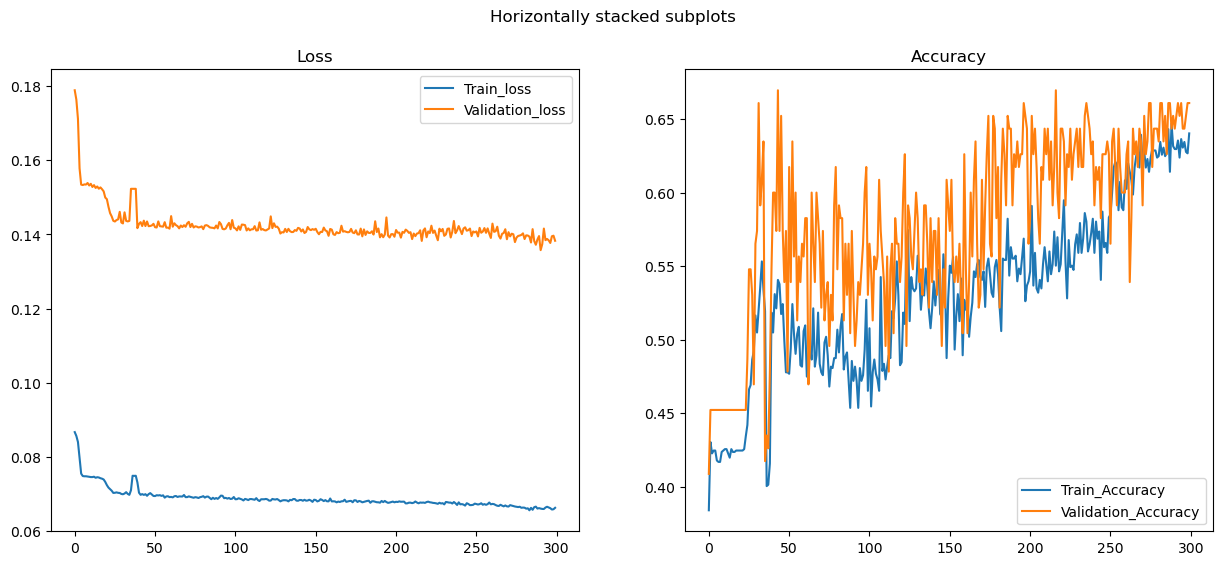

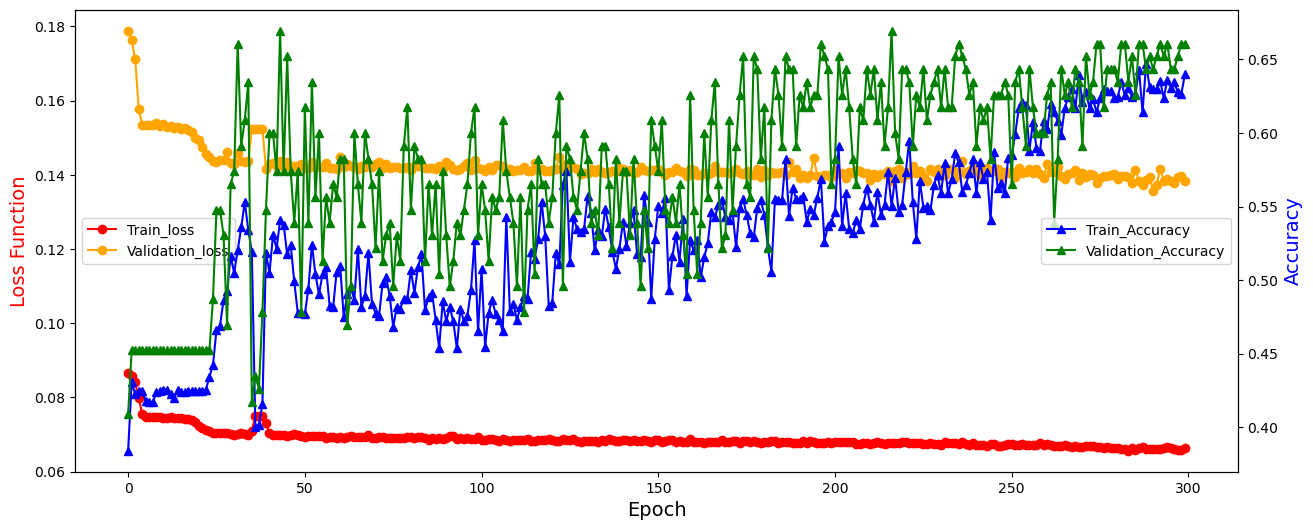

Current time: 95.800 minutes. Time expected till completion: 63.867 minutes

Epoch 301 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.06625218409864769
Val loss:  0.1374370523121046
train accuracy:  0.6363636363636364
Val accuracy:  0.6347826086956522
Current time: 96.114 minutes. Time expected till completion: 63.544 minutes

Epoch 302 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.06571250635143405
Val loss:  0.1397364652675131
train accuracy:  0.6199226305609284
Val accuracy:  0.6173913043478261
Current time: 96.427 minutes. Time expected till completion: 63.220 minutes

Epoch 303 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.06592971057679713
Val loss:  0.14068616628646852
train accuracy:  0.6141199226305609
Val accuracy:  0.6608695652173913
Current time: 96.742 minutes. Time expected till completion: 62.899 minutes

Epoch 304 of 500


100%|██████████| 15/15 [00:00<00:00, 16.19it/s]


train loss:  0.06606775862335929
Val loss:  0.13693179980568262
train accuracy:  0.6295938104448743
Val accuracy:  0.6434782608695652
Current time: 97.054 minutes. Time expected till completion: 62.575 minutes

Epoch 305 of 500


100%|██████████| 15/15 [00:00<00:00, 15.97it/s]


train loss:  0.06552512306770457
Val loss:  0.1357552979303443
train accuracy:  0.6334622823984526
Val accuracy:  0.6434782608695652
Current time: 97.368 minutes. Time expected till completion: 62.251 minutes

Epoch 306 of 500


100%|██████████| 15/15 [00:00<00:00, 16.10it/s]


train loss:  0.06626243661635157
Val loss:  0.13571903290955917
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 97.680 minutes. Time expected till completion: 61.928 minutes

Epoch 307 of 500


100%|██████████| 15/15 [00:00<00:00, 16.24it/s]


train loss:  0.06609505363082517
Val loss:  0.13656074897102688
train accuracy:  0.632495164410058
Val accuracy:  0.6521739130434783
Current time: 97.993 minutes. Time expected till completion: 61.605 minutes

Epoch 308 of 500


100%|██████████| 15/15 [00:00<00:00, 16.14it/s]


train loss:  0.06618133060475613
Val loss:  0.1368754153666289
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 98.305 minutes. Time expected till completion: 61.281 minutes

Epoch 309 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.06599882931036
Val loss:  0.13632995356684147
train accuracy:  0.6334622823984526
Val accuracy:  0.6434782608695652
Current time: 98.618 minutes. Time expected till completion: 60.958 minutes

Epoch 310 of 500


100%|██████████| 15/15 [00:00<00:00, 16.49it/s]


train loss:  0.06585162895329916
Val loss:  0.134921962281932
train accuracy:  0.6353965183752418
Val accuracy:  0.6521739130434783
Current time: 98.937 minutes. Time expected till completion: 60.639 minutes

Epoch 311 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.0660332364662473
Val loss:  0.1377145730930826
train accuracy:  0.6382978723404256
Val accuracy:  0.6521739130434783
Current time: 99.253 minutes. Time expected till completion: 60.318 minutes

Epoch 312 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.06633694207645247
Val loss:  0.1363883184350055
train accuracy:  0.6353965183752418
Val accuracy:  0.6608695652173913
Current time: 99.567 minutes. Time expected till completion: 59.996 minutes

Epoch 313 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.06603406061286853
Val loss:  0.13685359073721845
train accuracy:  0.6382978723404256
Val accuracy:  0.6521739130434783
Current time: 99.879 minutes. Time expected till completion: 59.672 minutes

Epoch 314 of 500


100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


train loss:  0.06609698103982199
Val loss:  0.13876151209292203
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 100.191 minutes. Time expected till completion: 59.349 minutes

Epoch 315 of 500


100%|██████████| 15/15 [00:00<00:00, 16.49it/s]


train loss:  0.06581873554786814
Val loss:  0.13915585486785226
train accuracy:  0.625725338491296
Val accuracy:  0.6434782608695652
Current time: 100.504 minutes. Time expected till completion: 59.026 minutes

Epoch 316 of 500


100%|██████████| 15/15 [00:00<00:00, 16.37it/s]


train loss:  0.06608755935552733
Val loss:  0.13656579100567362
train accuracy:  0.6218568665377177
Val accuracy:  0.6695652173913044
Current time: 100.815 minutes. Time expected till completion: 58.703 minutes

Epoch 317 of 500


100%|██████████| 15/15 [00:00<00:00, 15.75it/s]


train loss:  0.06554569018648025
Val loss:  0.13600162785986195
train accuracy:  0.6441005802707931
Val accuracy:  0.6434782608695652
Current time: 101.130 minutes. Time expected till completion: 58.381 minutes

Epoch 318 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.06570066675918476
Val loss:  0.13864935481030008
train accuracy:  0.6344294003868471
Val accuracy:  0.6521739130434783
Current time: 101.442 minutes. Time expected till completion: 58.058 minutes

Epoch 319 of 500


100%|██████████| 15/15 [00:00<00:00, 16.37it/s]


train loss:  0.06606181550994371
Val loss:  0.13863358393959377
train accuracy:  0.6382978723404256
Val accuracy:  0.6434782608695652
Current time: 101.755 minutes. Time expected till completion: 57.735 minutes

Epoch 320 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.06617775628599024
Val loss:  0.13653630173724632
train accuracy:  0.6295938104448743
Val accuracy:  0.6434782608695652
Current time: 102.069 minutes. Time expected till completion: 57.414 minutes

Epoch 321 of 500


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


train loss:  0.06610404101976804
Val loss:  0.13738315831059994
train accuracy:  0.6315280464216635
Val accuracy:  0.6521739130434783
Current time: 102.381 minutes. Time expected till completion: 57.091 minutes

Epoch 322 of 500


100%|██████████| 15/15 [00:00<00:00, 16.02it/s]


train loss:  0.06551975870731952
Val loss:  0.13707237088161967
train accuracy:  0.6470019342359767
Val accuracy:  0.6434782608695652
Current time: 102.693 minutes. Time expected till completion: 56.768 minutes

Epoch 323 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.06617665873044233
Val loss:  0.1355551486429961
train accuracy:  0.6344294003868471
Val accuracy:  0.6608695652173913
Current time: 103.010 minutes. Time expected till completion: 56.448 minutes

Epoch 324 of 500


100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


train loss:  0.06583220435295621
Val loss:  0.13726398426553477
train accuracy:  0.632495164410058
Val accuracy:  0.6521739130434783
Current time: 103.323 minutes. Time expected till completion: 56.126 minutes

Epoch 325 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.0660135341912681
Val loss:  0.13644114421761555
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 103.635 minutes. Time expected till completion: 55.803 minutes

Epoch 326 of 500


100%|██████████| 15/15 [00:00<00:00, 16.14it/s]


train loss:  0.06575786041337241
Val loss:  0.13649054921191672
train accuracy:  0.6382978723404256
Val accuracy:  0.6521739130434783
Current time: 103.948 minutes. Time expected till completion: 55.481 minutes

Epoch 327 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.06517467969160246
Val loss:  0.13585078457127447
train accuracy:  0.6315280464216635
Val accuracy:  0.6608695652173913
Current time: 104.258 minutes. Time expected till completion: 55.158 minutes

Epoch 328 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.06619633760166353
Val loss:  0.13546921118446018
train accuracy:  0.6344294003868471
Val accuracy:  0.6521739130434783
Current time: 104.572 minutes. Time expected till completion: 54.836 minutes

Epoch 329 of 500


100%|██████████| 15/15 [00:00<00:00, 16.17it/s]


train loss:  0.06599293415735492
Val loss:  0.13980155561281288
train accuracy:  0.6402321083172147
Val accuracy:  0.6434782608695652
Current time: 104.885 minutes. Time expected till completion: 54.514 minutes

Epoch 330 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.0653777400345129
Val loss:  0.13725008705387945
train accuracy:  0.6421663442940039
Val accuracy:  0.6434782608695652
Current time: 105.196 minutes. Time expected till completion: 54.192 minutes

Epoch 331 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.06568859151530312
Val loss:  0.13780786213667495
train accuracy:  0.6363636363636364
Val accuracy:  0.6434782608695652
Current time: 105.508 minutes. Time expected till completion: 53.870 minutes

Epoch 332 of 500


100%|██████████| 15/15 [00:00<00:00, 16.64it/s]


train loss:  0.06585951423276093
Val loss:  0.13793010348859042
train accuracy:  0.6353965183752418
Val accuracy:  0.6608695652173913
Current time: 105.818 minutes. Time expected till completion: 53.547 minutes

Epoch 333 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.06597041518821938
Val loss:  0.13827909956807677
train accuracy:  0.6189555125725339
Val accuracy:  0.6695652173913044
Current time: 106.133 minutes. Time expected till completion: 53.226 minutes

Epoch 334 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.06534331206888018
Val loss:  0.14222253509189772
train accuracy:  0.6315280464216635
Val accuracy:  0.6521739130434783
Current time: 106.446 minutes. Time expected till completion: 52.904 minutes

Epoch 335 of 500


100%|██████████| 15/15 [00:00<00:00, 15.67it/s]


train loss:  0.06577500366611222
Val loss:  0.13715852758158809
train accuracy:  0.6431334622823984
Val accuracy:  0.6521739130434783
Current time: 106.764 minutes. Time expected till completion: 52.585 minutes

Epoch 336 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.06586558214700429
Val loss:  0.1387585779894953
train accuracy:  0.648936170212766
Val accuracy:  0.6521739130434783
Current time: 107.081 minutes. Time expected till completion: 52.266 minutes

Epoch 337 of 500


100%|██████████| 15/15 [00:00<00:00, 16.19it/s]


train loss:  0.0658616324457947
Val loss:  0.13960722011068594
train accuracy:  0.6305609284332688
Val accuracy:  0.6434782608695652
Current time: 107.399 minutes. Time expected till completion: 51.947 minutes

Epoch 338 of 500


100%|██████████| 15/15 [00:00<00:00, 16.07it/s]


train loss:  0.06570818991448939
Val loss:  0.14352826916653177
train accuracy:  0.6411992263056093
Val accuracy:  0.6521739130434783
Current time: 107.715 minutes. Time expected till completion: 51.627 minutes

Epoch 339 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.06616619650123198
Val loss:  0.14268679826155953
train accuracy:  0.6344294003868471
Val accuracy:  0.6608695652173913
Current time: 108.033 minutes. Time expected till completion: 51.308 minutes

Epoch 340 of 500


100%|██████████| 15/15 [00:00<00:00, 15.55it/s]


train loss:  0.06639266037157011
Val loss:  0.14000845162764838
train accuracy:  0.6344294003868471
Val accuracy:  0.6521739130434783
Current time: 108.351 minutes. Time expected till completion: 50.989 minutes

Epoch 341 of 500


100%|██████████| 15/15 [00:00<00:00, 16.28it/s]


train loss:  0.06573597374921611
Val loss:  0.13940775135289069
train accuracy:  0.6421663442940039
Val accuracy:  0.6608695652173913
Current time: 108.668 minutes. Time expected till completion: 50.669 minutes

Epoch 342 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.06607656639134168
Val loss:  0.13757775192675384
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 108.985 minutes. Time expected till completion: 50.350 minutes

Epoch 343 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.06530590329456144
Val loss:  0.13560553322667662
train accuracy:  0.6344294003868471
Val accuracy:  0.6434782608695652
Current time: 109.302 minutes. Time expected till completion: 50.031 minutes

Epoch 344 of 500


100%|██████████| 15/15 [00:00<00:00, 16.22it/s]


train loss:  0.0655692418032043
Val loss:  0.13759362334790437
train accuracy:  0.6392649903288201
Val accuracy:  0.6521739130434783
Current time: 109.621 minutes. Time expected till completion: 49.712 minutes

Epoch 345 of 500


100%|██████████| 15/15 [00:00<00:00, 15.82it/s]


train loss:  0.06569036005544017
Val loss:  0.13831339193427045
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 109.937 minutes. Time expected till completion: 49.392 minutes

Epoch 346 of 500


100%|██████████| 15/15 [00:00<00:00, 16.19it/s]


train loss:  0.06579657535949575
Val loss:  0.14009697333626125
train accuracy:  0.6237911025145068
Val accuracy:  0.6521739130434783
Current time: 110.255 minutes. Time expected till completion: 49.073 minutes

Epoch 347 of 500


100%|██████████| 15/15 [00:00<00:00, 16.21it/s]


train loss:  0.06571214618719753
Val loss:  0.14044579993123593
train accuracy:  0.6470019342359767
Val accuracy:  0.6521739130434783
Current time: 110.572 minutes. Time expected till completion: 48.754 minutes

Epoch 348 of 500


100%|██████████| 15/15 [00:00<00:00, 16.22it/s]


train loss:  0.06554534598983233
Val loss:  0.13825277556543764
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 110.888 minutes. Time expected till completion: 48.434 minutes

Epoch 349 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.06564475950466134
Val loss:  0.137094333379165
train accuracy:  0.6344294003868471
Val accuracy:  0.6695652173913044
Current time: 111.205 minutes. Time expected till completion: 48.115 minutes

Epoch 350 of 500


100%|██████████| 15/15 [00:00<00:00, 15.54it/s]


train loss:  0.0655480417453574
Val loss:  0.13732963852260424
train accuracy:  0.6353965183752418
Val accuracy:  0.6347826086956522
Current time: 111.526 minutes. Time expected till completion: 47.797 minutes

Epoch 351 of 500


100%|██████████| 15/15 [00:00<00:00, 16.21it/s]


train loss:  0.06550127630999286
Val loss:  0.13756367279135662
train accuracy:  0.6353965183752418
Val accuracy:  0.6695652173913044
Current time: 111.847 minutes. Time expected till completion: 47.479 minutes

Epoch 352 of 500


100%|██████████| 15/15 [00:00<00:00, 16.12it/s]


train loss:  0.06580850222585741
Val loss:  0.13942082809365314
train accuracy:  0.6411992263056093
Val accuracy:  0.6434782608695652
Current time: 112.163 minutes. Time expected till completion: 47.160 minutes

Epoch 353 of 500


100%|██████████| 15/15 [00:00<00:00, 16.14it/s]


train loss:  0.06509941862445735
Val loss:  0.14047152788742728
train accuracy:  0.6431334622823984
Val accuracy:  0.6521739130434783
Current time: 112.483 minutes. Time expected till completion: 46.841 minutes

Epoch 354 of 500


100%|██████████| 15/15 [00:00<00:00, 16.28it/s]


train loss:  0.06598359502030526
Val loss:  0.1421463862709377
train accuracy:  0.6547388781431335
Val accuracy:  0.6521739130434783
Current time: 112.800 minutes. Time expected till completion: 46.522 minutes

Epoch 355 of 500


100%|██████████| 15/15 [00:00<00:00, 15.35it/s]


train loss:  0.06550749363936123
Val loss:  0.13800403812657233
train accuracy:  0.6470019342359767
Val accuracy:  0.6782608695652174
Current time: 113.119 minutes. Time expected till completion: 46.203 minutes

Epoch 356 of 500


100%|██████████| 15/15 [00:00<00:00, 16.10it/s]


train loss:  0.06579448689113963
Val loss:  0.13908754639003587
train accuracy:  0.6363636363636364
Val accuracy:  0.6608695652173913
Current time: 113.436 minutes. Time expected till completion: 45.884 minutes

Epoch 357 of 500


100%|██████████| 15/15 [00:00<00:00, 15.93it/s]


train loss:  0.06533581963821353
Val loss:  0.13777851643769637
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 113.752 minutes. Time expected till completion: 45.565 minutes

Epoch 358 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.06544116612098665
Val loss:  0.1383099975793258
train accuracy:  0.6373307543520309
Val accuracy:  0.6608695652173913
Current time: 114.074 minutes. Time expected till completion: 45.247 minutes

Epoch 359 of 500


100%|██████████| 15/15 [00:00<00:00, 16.30it/s]


train loss:  0.06594471007989039
Val loss:  0.1395628835843957
train accuracy:  0.6421663442940039
Val accuracy:  0.6695652173913044
Current time: 114.390 minutes. Time expected till completion: 44.928 minutes

Epoch 360 of 500


100%|██████████| 15/15 [00:00<00:00, 15.92it/s]


train loss:  0.06620628097071177
Val loss:  0.13727753991666047
train accuracy:  0.6344294003868471
Val accuracy:  0.6434782608695652
Current time: 114.707 minutes. Time expected till completion: 44.608 minutes

Epoch 361 of 500


100%|██████████| 15/15 [00:00<00:00, 16.10it/s]


train loss:  0.06583452386136673
Val loss:  0.13675702447476595
train accuracy:  0.6373307543520309
Val accuracy:  0.6347826086956522
Current time: 115.024 minutes. Time expected till completion: 44.289 minutes

Epoch 362 of 500


100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


train loss:  0.06568152254278009
Val loss:  0.1396615971689639
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 115.340 minutes. Time expected till completion: 43.969 minutes

Epoch 363 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.06531860997875147
Val loss:  0.13821331936380138
train accuracy:  0.6286266924564797
Val accuracy:  0.6521739130434783
Current time: 115.656 minutes. Time expected till completion: 43.650 minutes

Epoch 364 of 500


100%|██████████| 15/15 [00:00<00:00, 16.05it/s]


train loss:  0.06503606470917825
Val loss:  0.13814307399418044
train accuracy:  0.6373307543520309
Val accuracy:  0.6608695652173913
Current time: 115.973 minutes. Time expected till completion: 43.331 minutes

Epoch 365 of 500


100%|██████████| 15/15 [00:00<00:00, 16.15it/s]


train loss:  0.06510977778490093
Val loss:  0.13966948312261832
train accuracy:  0.6382978723404256
Val accuracy:  0.6521739130434783
Current time: 116.290 minutes. Time expected till completion: 43.011 minutes

Epoch 366 of 500


100%|██████████| 15/15 [00:00<00:00, 15.88it/s]


train loss:  0.06543454965954823
Val loss:  0.13702006443687106
train accuracy:  0.6402321083172147
Val accuracy:  0.6434782608695652
Current time: 116.609 minutes. Time expected till completion: 42.693 minutes

Epoch 367 of 500


100%|██████████| 15/15 [00:00<00:00, 16.14it/s]


train loss:  0.06582425491491646
Val loss:  0.13612173640209696
train accuracy:  0.6286266924564797
Val accuracy:  0.6521739130434783
Current time: 116.928 minutes. Time expected till completion: 42.374 minutes

Epoch 368 of 500


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


train loss:  0.06518500916501309
Val loss:  0.1390750237133192
train accuracy:  0.6450676982591876
Val accuracy:  0.6434782608695652
Current time: 117.244 minutes. Time expected till completion: 42.055 minutes

Epoch 369 of 500


100%|██████████| 15/15 [00:00<00:00, 16.14it/s]


train loss:  0.06537930970035162
Val loss:  0.13776417348695838
train accuracy:  0.632495164410058
Val accuracy:  0.6434782608695652
Current time: 117.562 minutes. Time expected till completion: 41.736 minutes

Epoch 370 of 500


100%|██████████| 15/15 [00:00<00:00, 16.19it/s]


train loss:  0.06503847454687152
Val loss:  0.1349715362424436
train accuracy:  0.6411992263056093
Val accuracy:  0.6521739130434783
Current time: 117.880 minutes. Time expected till completion: 41.417 minutes

Epoch 371 of 500


100%|██████████| 15/15 [00:00<00:00, 15.88it/s]


train loss:  0.06528078864114197
Val loss:  0.13808044506155925
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 118.198 minutes. Time expected till completion: 41.098 minutes

Epoch 372 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.06505512147853637
Val loss:  0.13838683885076772
train accuracy:  0.6402321083172147
Val accuracy:  0.6434782608695652
Current time: 118.516 minutes. Time expected till completion: 40.780 minutes

Epoch 373 of 500


100%|██████████| 15/15 [00:00<00:00, 16.24it/s]


train loss:  0.06561796969555794
Val loss:  0.13745846074560414
train accuracy:  0.6382978723404256
Val accuracy:  0.6521739130434783
Current time: 118.833 minutes. Time expected till completion: 40.460 minutes

Epoch 374 of 500


100%|██████████| 15/15 [00:00<00:00, 16.17it/s]


train loss:  0.06571014920101867
Val loss:  0.1377923530081044
train accuracy:  0.6392649903288201
Val accuracy:  0.6521739130434783
Current time: 119.150 minutes. Time expected till completion: 40.141 minutes

Epoch 375 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.0653125916966156
Val loss:  0.13520227515179178
train accuracy:  0.6382978723404256
Val accuracy:  0.6521739130434783
Current time: 119.468 minutes. Time expected till completion: 39.823 minutes

Epoch 376 of 500


100%|██████████| 15/15 [00:00<00:00, 15.93it/s]


train loss:  0.06517137307493553
Val loss:  0.13793085191560828
train accuracy:  0.6402321083172147
Val accuracy:  0.6608695652173913
Current time: 119.786 minutes. Time expected till completion: 39.504 minutes

Epoch 377 of 500


100%|██████████| 15/15 [00:00<00:00, 16.24it/s]


train loss:  0.06513665786564235
Val loss:  0.13759198396102243
train accuracy:  0.6441005802707931
Val accuracy:  0.6521739130434783
Current time: 120.104 minutes. Time expected till completion: 39.185 minutes

Epoch 378 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.06526605384262203
Val loss:  0.13824786984402201
train accuracy:  0.6518375241779497
Val accuracy:  0.6521739130434783
Current time: 120.426 minutes. Time expected till completion: 38.868 minutes

Epoch 379 of 500


100%|██████████| 15/15 [00:00<00:00, 16.12it/s]


train loss:  0.06534788600480763
Val loss:  0.13793174080226733
train accuracy:  0.6334622823984526
Val accuracy:  0.6521739130434783
Current time: 120.743 minutes. Time expected till completion: 38.549 minutes

Epoch 380 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.06496778960615339
Val loss:  0.136779260635376
train accuracy:  0.6479690522243714
Val accuracy:  0.6521739130434783
Current time: 121.061 minutes. Time expected till completion: 38.230 minutes

Epoch 381 of 500


100%|██████████| 15/15 [00:00<00:00, 15.83it/s]


train loss:  0.06511231761144716
Val loss:  0.1388385570567587
train accuracy:  0.6411992263056093
Val accuracy:  0.6347826086956522
Current time: 121.378 minutes. Time expected till completion: 37.911 minutes

Epoch 382 of 500


100%|██████████| 15/15 [00:00<00:00, 16.24it/s]


train loss:  0.06518521195915267
Val loss:  0.1382427215576172
train accuracy:  0.6460348162475822
Val accuracy:  0.6521739130434783
Current time: 121.696 minutes. Time expected till completion: 37.592 minutes

Epoch 383 of 500


100%|██████████| 15/15 [00:00<00:00, 16.21it/s]


train loss:  0.06574664551699877
Val loss:  0.1386858909026436
train accuracy:  0.6392649903288201
Val accuracy:  0.6608695652173913
Current time: 122.014 minutes. Time expected till completion: 37.273 minutes

Epoch 384 of 500


100%|██████████| 15/15 [00:00<00:00, 15.72it/s]


train loss:  0.06503738344753272
Val loss:  0.13684014496595964
train accuracy:  0.6344294003868471
Val accuracy:  0.6521739130434783
Current time: 122.331 minutes. Time expected till completion: 36.954 minutes

Epoch 385 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.06522703603111799
Val loss:  0.13797286178754722
train accuracy:  0.6373307543520309
Val accuracy:  0.6434782608695652
Current time: 122.647 minutes. Time expected till completion: 36.635 minutes

Epoch 386 of 500


100%|██████████| 15/15 [00:00<00:00, 15.82it/s]


train loss:  0.06569965745770955
Val loss:  0.13853266342826512
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 122.966 minutes. Time expected till completion: 36.317 minutes

Epoch 387 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.06536716960615531
Val loss:  0.1359489995500316
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 123.284 minutes. Time expected till completion: 35.998 minutes

Epoch 388 of 500


100%|██████████| 15/15 [00:00<00:00, 16.12it/s]


train loss:  0.06532649808280473
Val loss:  0.13853293812793235
train accuracy:  0.6286266924564797
Val accuracy:  0.6434782608695652
Current time: 123.603 minutes. Time expected till completion: 35.679 minutes

Epoch 389 of 500


100%|██████████| 15/15 [00:00<00:00, 16.14it/s]


train loss:  0.06551869389397494
Val loss:  0.1386224751887114
train accuracy:  0.6286266924564797
Val accuracy:  0.6260869565217392
Current time: 123.919 minutes. Time expected till completion: 35.360 minutes

Epoch 390 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.06502731349067024
Val loss:  0.13687170536621757
train accuracy:  0.6431334622823984
Val accuracy:  0.6608695652173913
Current time: 124.235 minutes. Time expected till completion: 35.041 minutes

Epoch 391 of 500


100%|██████████| 15/15 [00:00<00:00, 16.00it/s]


train loss:  0.06519587623312119
Val loss:  0.13622689247131348
train accuracy:  0.6470019342359767
Val accuracy:  0.6521739130434783
Current time: 124.554 minutes. Time expected till completion: 34.722 minutes

Epoch 392 of 500


100%|██████████| 15/15 [00:00<00:00, 15.73it/s]


train loss:  0.06490291675239282
Val loss:  0.1347097018490667
train accuracy:  0.6315280464216635
Val accuracy:  0.6608695652173913
Current time: 124.872 minutes. Time expected till completion: 34.403 minutes

Epoch 393 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.06507461473374579
Val loss:  0.14333038796549258
train accuracy:  0.6392649903288201
Val accuracy:  0.6434782608695652
Current time: 125.192 minutes. Time expected till completion: 34.085 minutes

Epoch 394 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.06564307743161052
Val loss:  0.13794736654862114
train accuracy:  0.6499032882011605
Val accuracy:  0.6521739130434783
Current time: 125.509 minutes. Time expected till completion: 33.766 minutes

Epoch 395 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.06474687663452769
Val loss:  0.13754146099090575
train accuracy:  0.620889748549323
Val accuracy:  0.6347826086956522
Current time: 125.826 minutes. Time expected till completion: 33.447 minutes

Epoch 396 of 500


100%|██████████| 15/15 [00:00<00:00, 15.83it/s]


train loss:  0.06553190289429124
Val loss:  0.13495490032693613
train accuracy:  0.6373307543520309
Val accuracy:  0.6695652173913044
Current time: 126.148 minutes. Time expected till completion: 33.130 minutes

Epoch 397 of 500


100%|██████████| 15/15 [00:00<00:00, 15.93it/s]


train loss:  0.06511435431484097
Val loss:  0.1378410904303841
train accuracy:  0.6228239845261122
Val accuracy:  0.6695652173913044
Current time: 126.483 minutes. Time expected till completion: 32.815 minutes

Epoch 398 of 500


100%|██████████| 15/15 [00:00<00:00, 16.19it/s]


train loss:  0.06511926339719466
Val loss:  0.1403453184210736
train accuracy:  0.6431334622823984
Val accuracy:  0.6521739130434783
Current time: 126.800 minutes. Time expected till completion: 32.496 minutes

Epoch 399 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.06545386277499467
Val loss:  0.1395719491917154
train accuracy:  0.6373307543520309
Val accuracy:  0.6521739130434783
Current time: 127.116 minutes. Time expected till completion: 32.177 minutes

Epoch 400 of 500


100%|██████████| 15/15 [00:00<00:00, 15.67it/s]


train loss:  0.0648272091115697
Val loss:  0.1390848097593888
train accuracy:  0.6421663442940039
Val accuracy:  0.6521739130434783
Saving model checkpoint


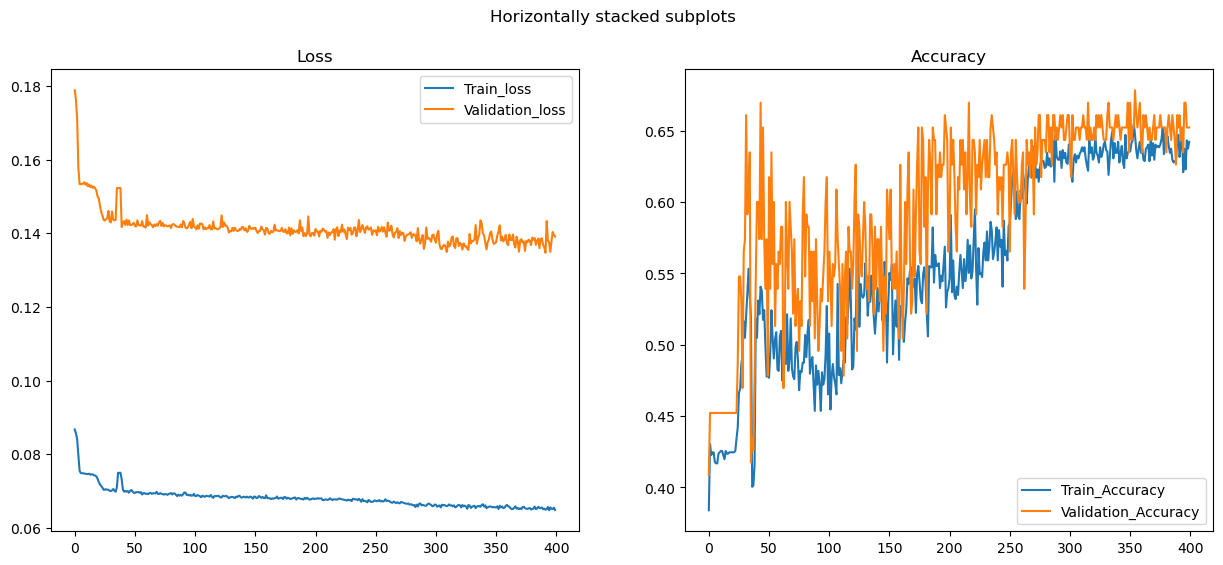

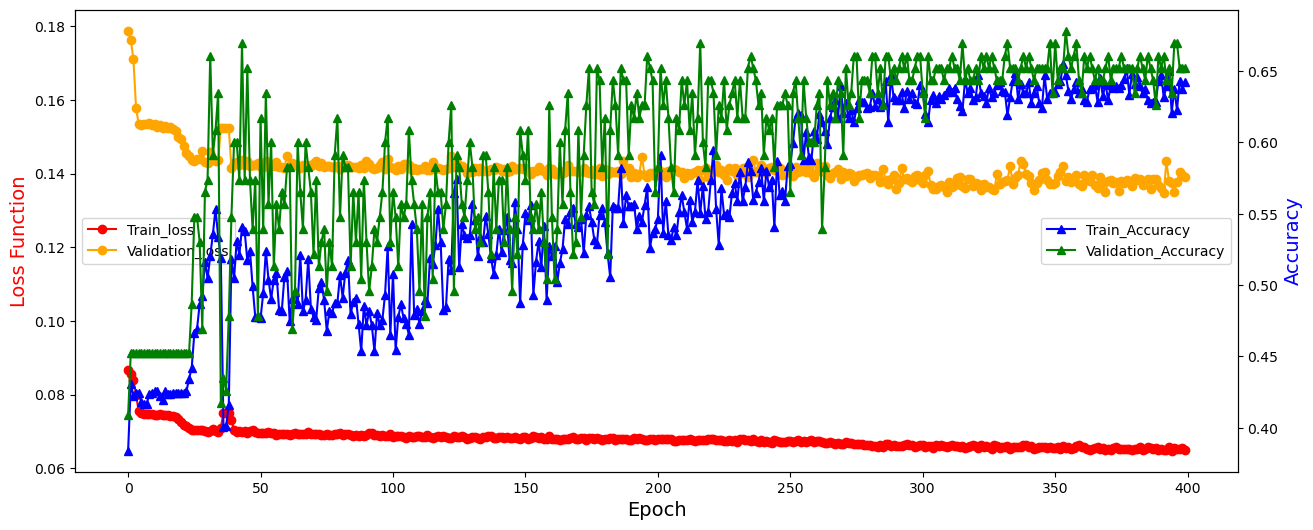

Current time: 127.472 minutes. Time expected till completion: 31.868 minutes

Epoch 401 of 500


100%|██████████| 15/15 [00:00<00:00, 15.62it/s]


train loss:  0.06564096821115371
Val loss:  0.1411844720011172
train accuracy:  0.625725338491296
Val accuracy:  0.6434782608695652
Current time: 127.843 minutes. Time expected till completion: 31.562 minutes

Epoch 402 of 500


100%|██████████| 15/15 [00:00<00:00, 16.49it/s]


train loss:  0.06514526082191983
Val loss:  0.13630292726599652
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 128.175 minutes. Time expected till completion: 31.247 minutes

Epoch 403 of 500


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


train loss:  0.06521682346120794
Val loss:  0.13803734883018162
train accuracy:  0.6344294003868471
Val accuracy:  0.6434782608695652
Current time: 128.490 minutes. Time expected till completion: 30.927 minutes

Epoch 404 of 500


100%|██████████| 15/15 [00:00<00:00, 15.16it/s]


train loss:  0.06504873121499555
Val loss:  0.1349218373713286
train accuracy:  0.6353965183752418
Val accuracy:  0.6521739130434783
Current time: 128.828 minutes. Time expected till completion: 30.613 minutes

Epoch 405 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.06478876278986091
Val loss:  0.13609584207120148
train accuracy:  0.625725338491296
Val accuracy:  0.6347826086956522
Current time: 129.150 minutes. Time expected till completion: 30.294 minutes

Epoch 406 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.06520235244494572
Val loss:  0.1385646633479906
train accuracy:  0.6344294003868471
Val accuracy:  0.6434782608695652
Current time: 129.463 minutes. Time expected till completion: 29.974 minutes

Epoch 407 of 500


100%|██████████| 15/15 [00:00<00:00, 16.53it/s]


train loss:  0.06483704526143101
Val loss:  0.1368660392968551
train accuracy:  0.6363636363636364
Val accuracy:  0.6434782608695652
Current time: 129.776 minutes. Time expected till completion: 29.654 minutes

Epoch 408 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.06529438893384583
Val loss:  0.13855781762496286
train accuracy:  0.6411992263056093
Val accuracy:  0.6608695652173913
Current time: 130.089 minutes. Time expected till completion: 29.334 minutes

Epoch 409 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.06491919193323162
Val loss:  0.13690278892931732
train accuracy:  0.632495164410058
Val accuracy:  0.6521739130434783
Current time: 130.403 minutes. Time expected till completion: 29.014 minutes

Epoch 410 of 500


100%|██████████| 15/15 [00:00<00:00, 16.17it/s]


train loss:  0.0645643730919873
Val loss:  0.13595007295193878
train accuracy:  0.6508704061895552
Val accuracy:  0.6608695652173913
Current time: 130.717 minutes. Time expected till completion: 28.694 minutes

Epoch 411 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.06507477573546035
Val loss:  0.13806379670682162
train accuracy:  0.6286266924564797
Val accuracy:  0.6260869565217392
Current time: 131.031 minutes. Time expected till completion: 28.374 minutes

Epoch 412 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.06547668166962999
Val loss:  0.13596017360687257
train accuracy:  0.6295938104448743
Val accuracy:  0.6521739130434783
Current time: 131.351 minutes. Time expected till completion: 28.056 minutes

Epoch 413 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.06479444465738662
Val loss:  0.1418409850286401
train accuracy:  0.6373307543520309
Val accuracy:  0.6521739130434783
Current time: 131.665 minutes. Time expected till completion: 27.736 minutes

Epoch 414 of 500


100%|██████████| 15/15 [00:00<00:00, 16.37it/s]


train loss:  0.06513573906638405
Val loss:  0.1368401211241017
train accuracy:  0.6286266924564797
Val accuracy:  0.6434782608695652
Current time: 131.978 minutes. Time expected till completion: 27.416 minutes

Epoch 415 of 500


100%|██████████| 15/15 [00:00<00:00, 15.83it/s]


train loss:  0.06570671495893246
Val loss:  0.13875605230746063
train accuracy:  0.632495164410058
Val accuracy:  0.6521739130434783
Current time: 132.290 minutes. Time expected till completion: 27.096 minutes

Epoch 416 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.0650630973178598
Val loss:  0.13736486279446145
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 132.607 minutes. Time expected till completion: 26.776 minutes

Epoch 417 of 500


100%|██████████| 15/15 [00:00<00:00, 16.28it/s]


train loss:  0.06532765633824715
Val loss:  0.13698246738185052
train accuracy:  0.6334622823984526
Val accuracy:  0.6695652173913044
Current time: 132.921 minutes. Time expected till completion: 26.457 minutes

Epoch 418 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.065302100472109
Val loss:  0.13810515870218693
train accuracy:  0.6344294003868471
Val accuracy:  0.6434782608695652
Current time: 133.234 minutes. Time expected till completion: 26.137 minutes

Epoch 419 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.06489071382544719
Val loss:  0.13915288033692733
train accuracy:  0.6373307543520309
Val accuracy:  0.6695652173913044
Current time: 133.549 minutes. Time expected till completion: 25.817 minutes

Epoch 420 of 500


100%|██████████| 15/15 [00:00<00:00, 15.25it/s]


train loss:  0.06497671041543987
Val loss:  0.13630841503972593
train accuracy:  0.6411992263056093
Val accuracy:  0.6521739130434783
Current time: 133.864 minutes. Time expected till completion: 25.498 minutes

Epoch 421 of 500


100%|██████████| 15/15 [00:00<00:00, 15.92it/s]


train loss:  0.06479373314855638
Val loss:  0.13779424947241078
train accuracy:  0.6286266924564797
Val accuracy:  0.6521739130434783
Current time: 134.188 minutes. Time expected till completion: 25.180 minutes

Epoch 422 of 500


100%|██████████| 15/15 [00:00<00:00, 16.60it/s]


train loss:  0.06493740363093363
Val loss:  0.13514914305313774
train accuracy:  0.6382978723404256
Val accuracy:  0.6521739130434783
Current time: 134.504 minutes. Time expected till completion: 24.861 minutes

Epoch 423 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.06535047828805285
Val loss:  0.13469858843347302
train accuracy:  0.6179883945841392
Val accuracy:  0.6521739130434783
Current time: 134.818 minutes. Time expected till completion: 24.541 minutes

Epoch 424 of 500


100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


train loss:  0.06530362419510256
Val loss:  0.135127011589382
train accuracy:  0.6295938104448743
Val accuracy:  0.6521739130434783
Current time: 135.133 minutes. Time expected till completion: 24.222 minutes

Epoch 425 of 500


100%|██████████| 15/15 [00:00<00:00, 16.37it/s]


train loss:  0.0651761897527964
Val loss:  0.13693533099215963
train accuracy:  0.6266924564796905
Val accuracy:  0.6695652173913044
Current time: 135.446 minutes. Time expected till completion: 23.902 minutes

Epoch 426 of 500


100%|██████████| 15/15 [00:00<00:00, 15.98it/s]


train loss:  0.06486262441603773
Val loss:  0.13746314981709357
train accuracy:  0.6470019342359767
Val accuracy:  0.6608695652173913
Current time: 135.760 minutes. Time expected till completion: 23.583 minutes

Epoch 427 of 500


100%|██████████| 15/15 [00:00<00:00, 16.17it/s]


train loss:  0.06540538056445537
Val loss:  0.13916420262792836
train accuracy:  0.6441005802707931
Val accuracy:  0.6608695652173913
Current time: 136.077 minutes. Time expected till completion: 23.264 minutes

Epoch 428 of 500


100%|██████████| 15/15 [00:00<00:00, 16.49it/s]


train loss:  0.06525424434091874
Val loss:  0.1385445465212283
train accuracy:  0.6344294003868471
Val accuracy:  0.6608695652173913
Current time: 136.391 minutes. Time expected till completion: 22.944 minutes

Epoch 429 of 500


100%|██████████| 15/15 [00:00<00:00, 16.05it/s]


train loss:  0.06511037371605922
Val loss:  0.1360660055409307
train accuracy:  0.6392649903288201
Val accuracy:  0.6434782608695652
Current time: 136.707 minutes. Time expected till completion: 22.625 minutes

Epoch 430 of 500


100%|██████████| 15/15 [00:00<00:00, 15.95it/s]


train loss:  0.06464104974062346
Val loss:  0.13724219488060993
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 137.024 minutes. Time expected till completion: 22.306 minutes

Epoch 431 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.06497087613526349
Val loss:  0.1394583225250244
train accuracy:  0.6305609284332688
Val accuracy:  0.6608695652173913
Current time: 137.339 minutes. Time expected till completion: 21.987 minutes

Epoch 432 of 500


100%|██████████| 15/15 [00:00<00:00, 15.88it/s]


train loss:  0.06505154958084888
Val loss:  0.13867741512215656
train accuracy:  0.6266924564796905
Val accuracy:  0.6521739130434783
Current time: 137.656 minutes. Time expected till completion: 21.668 minutes

Epoch 433 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.06484441923218955
Val loss:  0.13989752012750375
train accuracy:  0.6286266924564797
Val accuracy:  0.6521739130434783
Current time: 137.970 minutes. Time expected till completion: 21.349 minutes

Epoch 434 of 500


100%|██████████| 15/15 [00:00<00:00, 16.37it/s]


train loss:  0.06499674489696436
Val loss:  0.13801753728286079
train accuracy:  0.6276595744680851
Val accuracy:  0.6434782608695652
Current time: 138.283 minutes. Time expected till completion: 21.029 minutes

Epoch 435 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.06490949931873344
Val loss:  0.13412062033363012
train accuracy:  0.6266924564796905
Val accuracy:  0.6521739130434783
Current time: 138.599 minutes. Time expected till completion: 20.710 minutes

Epoch 436 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.06484041920713576
Val loss:  0.13895489703054015
train accuracy:  0.6295938104448743
Val accuracy:  0.6521739130434783
Current time: 138.913 minutes. Time expected till completion: 20.391 minutes

Epoch 437 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.0647498574432137
Val loss:  0.1361519694328308
train accuracy:  0.632495164410058
Val accuracy:  0.6782608695652174
Current time: 139.227 minutes. Time expected till completion: 20.072 minutes

Epoch 438 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.06508182095835702
Val loss:  0.13434729265130085
train accuracy:  0.6373307543520309
Val accuracy:  0.6521739130434783
Current time: 139.542 minutes. Time expected till completion: 19.753 minutes

Epoch 439 of 500


100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


train loss:  0.0647120363938278
Val loss:  0.13633265858111174
train accuracy:  0.6431334622823984
Val accuracy:  0.6608695652173913
Current time: 139.855 minutes. Time expected till completion: 19.433 minutes

Epoch 440 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.0644712977298685
Val loss:  0.13539821272311003
train accuracy:  0.6373307543520309
Val accuracy:  0.6608695652173913
Current time: 140.169 minutes. Time expected till completion: 19.114 minutes

Epoch 441 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.06462573803370418
Val loss:  0.13499940115472545
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 140.483 minutes. Time expected till completion: 18.795 minutes

Epoch 442 of 500


100%|██████████| 15/15 [00:00<00:00, 16.21it/s]


train loss:  0.06513591176997763
Val loss:  0.13687150478363036
train accuracy:  0.6334622823984526
Val accuracy:  0.6608695652173913
Current time: 140.797 minutes. Time expected till completion: 18.476 minutes

Epoch 443 of 500


100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


train loss:  0.06429252864313771
Val loss:  0.13863364924555238
train accuracy:  0.6266924564796905
Val accuracy:  0.6434782608695652
Current time: 141.111 minutes. Time expected till completion: 18.157 minutes

Epoch 444 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.06498930013848458
Val loss:  0.13633481004963752
train accuracy:  0.625725338491296
Val accuracy:  0.6434782608695652
Current time: 141.428 minutes. Time expected till completion: 17.838 minutes

Epoch 445 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.06473724402818735
Val loss:  0.13510944480481354
train accuracy:  0.6344294003868471
Val accuracy:  0.6521739130434783
Current time: 141.742 minutes. Time expected till completion: 17.519 minutes

Epoch 446 of 500


100%|██████████| 15/15 [00:00<00:00, 16.19it/s]


train loss:  0.06466141210533895
Val loss:  0.13596252565798553
train accuracy:  0.6305609284332688
Val accuracy:  0.6434782608695652
Current time: 142.059 minutes. Time expected till completion: 17.200 minutes

Epoch 447 of 500


100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


train loss:  0.06489616205890589
Val loss:  0.13753499207289321
train accuracy:  0.6402321083172147
Val accuracy:  0.6521739130434783
Current time: 142.377 minutes. Time expected till completion: 16.881 minutes

Epoch 448 of 500


100%|██████████| 15/15 [00:00<00:00, 15.88it/s]


train loss:  0.06511232401001153
Val loss:  0.13563595802887626
train accuracy:  0.6237911025145068
Val accuracy:  0.6695652173913044
Current time: 142.693 minutes. Time expected till completion: 16.563 minutes

Epoch 449 of 500


100%|██████████| 15/15 [00:00<00:00, 15.88it/s]


train loss:  0.06488945745868424
Val loss:  0.13472277858982915
train accuracy:  0.6315280464216635
Val accuracy:  0.6695652173913044
Current time: 143.012 minutes. Time expected till completion: 16.244 minutes

Epoch 450 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.06593627302512901
Val loss:  0.1407069797101228
train accuracy:  0.6247582205029013
Val accuracy:  0.6434782608695652
Current time: 143.325 minutes. Time expected till completion: 15.925 minutes

Epoch 451 of 500


100%|██████████| 15/15 [00:00<00:00, 16.46it/s]


train loss:  0.06493628411274584
Val loss:  0.13798583849616672
train accuracy:  0.6411992263056093
Val accuracy:  0.6434782608695652
Current time: 143.638 minutes. Time expected till completion: 15.606 minutes

Epoch 452 of 500


100%|██████████| 15/15 [00:00<00:00, 16.24it/s]


train loss:  0.06529405557440604
Val loss:  0.1359955829122792
train accuracy:  0.6218568665377177
Val accuracy:  0.6434782608695652
Current time: 143.952 minutes. Time expected till completion: 15.287 minutes

Epoch 453 of 500


100%|██████████| 15/15 [00:00<00:00, 16.53it/s]


train loss:  0.06476250769321877
Val loss:  0.1407276179479516
train accuracy:  0.6237911025145068
Val accuracy:  0.6434782608695652
Current time: 144.269 minutes. Time expected till completion: 14.968 minutes

Epoch 454 of 500


100%|██████████| 15/15 [00:00<00:00, 16.19it/s]


train loss:  0.06490175843930568
Val loss:  0.1395028705182283
train accuracy:  0.6334622823984526
Val accuracy:  0.6608695652173913
Current time: 144.588 minutes. Time expected till completion: 14.650 minutes

Epoch 455 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.0646965007371552
Val loss:  0.13465171689572542
train accuracy:  0.632495164410058
Val accuracy:  0.6521739130434783
Current time: 144.906 minutes. Time expected till completion: 14.331 minutes

Epoch 456 of 500


100%|██████████| 15/15 [00:00<00:00, 16.19it/s]


train loss:  0.06473200890727385
Val loss:  0.13646633573200392
train accuracy:  0.6421663442940039
Val accuracy:  0.6695652173913044
Current time: 145.221 minutes. Time expected till completion: 14.013 minutes

Epoch 457 of 500


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


train loss:  0.06455972196977419
Val loss:  0.1378869942996813
train accuracy:  0.6334622823984526
Val accuracy:  0.6347826086956522
Current time: 145.534 minutes. Time expected till completion: 13.694 minutes

Epoch 458 of 500


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


train loss:  0.0651438753309748
Val loss:  0.14041348488434502
train accuracy:  0.6344294003868471
Val accuracy:  0.6608695652173913
Current time: 145.849 minutes. Time expected till completion: 13.375 minutes

Epoch 459 of 500


100%|██████████| 15/15 [00:00<00:00, 16.00it/s]


train loss:  0.0644462687365091
Val loss:  0.14041942824488102
train accuracy:  0.6392649903288201
Val accuracy:  0.6521739130434783
Current time: 146.163 minutes. Time expected till completion: 13.056 minutes

Epoch 460 of 500


100%|██████████| 15/15 [00:00<00:00, 16.09it/s]


train loss:  0.06487877421960148
Val loss:  0.136498296779135
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 146.477 minutes. Time expected till completion: 12.737 minutes

Epoch 461 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.06463908394024036
Val loss:  0.13957551873248555
train accuracy:  0.6373307543520309
Val accuracy:  0.6521739130434783
Current time: 146.794 minutes. Time expected till completion: 12.419 minutes

Epoch 462 of 500


100%|██████████| 15/15 [00:00<00:00, 16.33it/s]


train loss:  0.06492019610432638
Val loss:  0.138410498784936
train accuracy:  0.6392649903288201
Val accuracy:  0.6608695652173913
Current time: 147.107 minutes. Time expected till completion: 12.100 minutes

Epoch 463 of 500


100%|██████████| 15/15 [00:00<00:00, 16.55it/s]


train loss:  0.06477115002084285
Val loss:  0.1390346770701201
train accuracy:  0.6353965183752418
Val accuracy:  0.6695652173913044
Current time: 147.420 minutes. Time expected till completion: 11.781 minutes

Epoch 464 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.06476502475009896
Val loss:  0.13559098088223
train accuracy:  0.6315280464216635
Val accuracy:  0.6608695652173913
Current time: 147.734 minutes. Time expected till completion: 11.462 minutes

Epoch 465 of 500


100%|██████████| 15/15 [00:00<00:00, 16.14it/s]


train loss:  0.06446166552704123
Val loss:  0.1389469333316969
train accuracy:  0.6402321083172147
Val accuracy:  0.6521739130434783
Current time: 148.047 minutes. Time expected till completion: 11.143 minutes

Epoch 466 of 500


100%|██████████| 15/15 [00:00<00:00, 16.53it/s]


train loss:  0.06461385267154392
Val loss:  0.14001905555310457
train accuracy:  0.6334622823984526
Val accuracy:  0.6434782608695652
Current time: 148.359 minutes. Time expected till completion: 10.824 minutes

Epoch 467 of 500


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


train loss:  0.06461212840255501
Val loss:  0.13646422469097635
train accuracy:  0.6315280464216635
Val accuracy:  0.6434782608695652
Current time: 148.672 minutes. Time expected till completion: 10.506 minutes

Epoch 468 of 500


100%|██████████| 15/15 [00:00<00:00, 16.28it/s]


train loss:  0.0648540244572859
Val loss:  0.13709873583005822
train accuracy:  0.6382978723404256
Val accuracy:  0.6521739130434783
Current time: 148.986 minutes. Time expected till completion: 10.187 minutes

Epoch 469 of 500


100%|██████████| 15/15 [00:00<00:00, 16.37it/s]


train loss:  0.06421366616420635
Val loss:  0.13675356429556143
train accuracy:  0.6479690522243714
Val accuracy:  0.6521739130434783
Current time: 149.299 minutes. Time expected till completion: 9.868 minutes

Epoch 470 of 500


100%|██████████| 15/15 [00:00<00:00, 16.51it/s]


train loss:  0.06431080207833931
Val loss:  0.1387013881102852
train accuracy:  0.6479690522243714
Val accuracy:  0.6521739130434783
Current time: 149.612 minutes. Time expected till completion: 9.550 minutes

Epoch 471 of 500


100%|██████████| 15/15 [00:00<00:00, 15.73it/s]


train loss:  0.06516119376603131
Val loss:  0.1408540005269258
train accuracy:  0.6344294003868471
Val accuracy:  0.6608695652173913
Current time: 149.926 minutes. Time expected till completion: 9.231 minutes

Epoch 472 of 500


100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


train loss:  0.06516429603215113
Val loss:  0.1363195616266002
train accuracy:  0.6431334622823984
Val accuracy:  0.6521739130434783
Current time: 150.242 minutes. Time expected till completion: 8.913 minutes

Epoch 473 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.06495763958076906
Val loss:  0.13860969647117283
train accuracy:  0.6237911025145068
Val accuracy:  0.6521739130434783
Current time: 150.556 minutes. Time expected till completion: 8.594 minutes

Epoch 474 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.06484701387886845
Val loss:  0.13503025822017503
train accuracy:  0.6305609284332688
Val accuracy:  0.6434782608695652
Current time: 150.870 minutes. Time expected till completion: 8.276 minutes

Epoch 475 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.06465519143257657
Val loss:  0.136070688392805
train accuracy:  0.6344294003868471
Val accuracy:  0.6434782608695652
Current time: 151.185 minutes. Time expected till completion: 7.957 minutes

Epoch 476 of 500


100%|██████████| 15/15 [00:00<00:00, 15.85it/s]


train loss:  0.06503349998011118
Val loss:  0.13626479065936545
train accuracy:  0.6315280464216635
Val accuracy:  0.6521739130434783
Current time: 151.498 minutes. Time expected till completion: 7.639 minutes

Epoch 477 of 500


100%|██████████| 15/15 [00:00<00:00, 16.24it/s]


train loss:  0.06448726070688125
Val loss:  0.14095353095427804
train accuracy:  0.6402321083172147
Val accuracy:  0.6434782608695652
Current time: 151.812 minutes. Time expected till completion: 7.320 minutes

Epoch 478 of 500


100%|██████████| 15/15 [00:00<00:00, 16.22it/s]


train loss:  0.06476229584885751
Val loss:  0.13852063261944314
train accuracy:  0.6344294003868471
Val accuracy:  0.6608695652173913
Current time: 152.127 minutes. Time expected till completion: 7.002 minutes

Epoch 479 of 500


100%|██████████| 15/15 [00:00<00:00, 16.49it/s]


train loss:  0.06499137044875257
Val loss:  0.1392073693482772
train accuracy:  0.6363636363636364
Val accuracy:  0.6608695652173913
Current time: 152.441 minutes. Time expected till completion: 6.683 minutes

Epoch 480 of 500


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


train loss:  0.06499446666217634
Val loss:  0.13742804527282715
train accuracy:  0.6373307543520309
Val accuracy:  0.6521739130434783
Current time: 152.755 minutes. Time expected till completion: 6.365 minutes

Epoch 481 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.06503434205424163
Val loss:  0.1365894685620847
train accuracy:  0.6228239845261122
Val accuracy:  0.6782608695652174
Current time: 153.069 minutes. Time expected till completion: 6.046 minutes

Epoch 482 of 500


100%|██████████| 15/15 [00:00<00:00, 15.92it/s]


train loss:  0.06488775711225588
Val loss:  0.13669857149538786
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 153.383 minutes. Time expected till completion: 5.728 minutes

Epoch 483 of 500


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


train loss:  0.06493892251177037
Val loss:  0.137608321853306
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 153.698 minutes. Time expected till completion: 5.410 minutes

Epoch 484 of 500


100%|██████████| 15/15 [00:00<00:00, 16.12it/s]


train loss:  0.06419730503508385
Val loss:  0.13880390706269638
train accuracy:  0.6344294003868471
Val accuracy:  0.6521739130434783
Current time: 154.011 minutes. Time expected till completion: 5.091 minutes

Epoch 485 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.06427685048870699
Val loss:  0.14011636454126108
train accuracy:  0.6441005802707931
Val accuracy:  0.6695652173913044
Current time: 154.325 minutes. Time expected till completion: 4.773 minutes

Epoch 486 of 500


100%|██████████| 15/15 [00:00<00:00, 16.28it/s]


train loss:  0.06481277954186415
Val loss:  0.13541241262270057
train accuracy:  0.6499032882011605
Val accuracy:  0.6521739130434783
Current time: 154.638 minutes. Time expected till completion: 4.455 minutes

Epoch 487 of 500


100%|██████████| 15/15 [00:00<00:00, 16.19it/s]


train loss:  0.0643143129302639
Val loss:  0.13640186475670857
train accuracy:  0.6382978723404256
Val accuracy:  0.6434782608695652
Current time: 154.951 minutes. Time expected till completion: 4.136 minutes

Epoch 488 of 500


100%|██████████| 15/15 [00:00<00:00, 15.90it/s]


train loss:  0.0647993916699688
Val loss:  0.1381139029627261
train accuracy:  0.6411992263056093
Val accuracy:  0.6521739130434783
Current time: 155.266 minutes. Time expected till completion: 3.818 minutes

Epoch 489 of 500


100%|██████████| 15/15 [00:00<00:00, 16.46it/s]


train loss:  0.06442115073969562
Val loss:  0.13657046815623408
train accuracy:  0.6382978723404256
Val accuracy:  0.6434782608695652
Current time: 155.578 minutes. Time expected till completion: 3.500 minutes

Epoch 490 of 500


100%|██████████| 15/15 [00:00<00:00, 16.46it/s]


train loss:  0.0646578386512439
Val loss:  0.13862439393997192
train accuracy:  0.6411992263056093
Val accuracy:  0.6521739130434783
Current time: 155.892 minutes. Time expected till completion: 3.181 minutes

Epoch 491 of 500


100%|██████████| 15/15 [00:00<00:00, 15.90it/s]


train loss:  0.06436356008629274
Val loss:  0.14060563056365302
train accuracy:  0.6460348162475822
Val accuracy:  0.6521739130434783
Current time: 156.209 minutes. Time expected till completion: 2.863 minutes

Epoch 492 of 500


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


train loss:  0.06457635673840226
Val loss:  0.13611581118210503
train accuracy:  0.6344294003868471
Val accuracy:  0.6608695652173913
Current time: 156.522 minutes. Time expected till completion: 2.545 minutes

Epoch 493 of 500


100%|██████████| 15/15 [00:00<00:00, 16.15it/s]


train loss:  0.06406531026100513
Val loss:  0.13673789501190187
train accuracy:  0.6382978723404256
Val accuracy:  0.6521739130434783
Current time: 156.836 minutes. Time expected till completion: 2.227 minutes

Epoch 494 of 500


100%|██████████| 15/15 [00:00<00:00, 16.28it/s]


train loss:  0.06452062276391965
Val loss:  0.13914050433946692
train accuracy:  0.6334622823984526
Val accuracy:  0.6521739130434783
Current time: 157.151 minutes. Time expected till completion: 1.909 minutes

Epoch 495 of 500


100%|██████████| 15/15 [00:00<00:00, 16.46it/s]


train loss:  0.06400993074393134
Val loss:  0.13839303825212562
train accuracy:  0.6431334622823984
Val accuracy:  0.6434782608695652
Current time: 157.465 minutes. Time expected till completion: 1.591 minutes

Epoch 496 of 500


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


train loss:  0.06443384987242678
Val loss:  0.1347094432167385
train accuracy:  0.6363636363636364
Val accuracy:  0.6608695652173913
Current time: 157.780 minutes. Time expected till completion: 1.272 minutes

Epoch 497 of 500


100%|██████████| 15/15 [00:00<00:00, 16.49it/s]


train loss:  0.06429917311991207
Val loss:  0.13897354188172714
train accuracy:  0.6353965183752418
Val accuracy:  0.6521739130434783
Current time: 158.092 minutes. Time expected till completion: 0.954 minutes

Epoch 498 of 500


100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


train loss:  0.06470337095066934
Val loss:  0.1398718870204428
train accuracy:  0.632495164410058
Val accuracy:  0.6521739130434783
Current time: 158.408 minutes. Time expected till completion: 0.636 minutes

Epoch 499 of 500


100%|██████████| 15/15 [00:00<00:00, 15.87it/s]


train loss:  0.0646089757549463
Val loss:  0.13921701286150062
train accuracy:  0.6363636363636364
Val accuracy:  0.6695652173913044
Current time: 158.721 minutes. Time expected till completion: 0.318 minutes

Epoch 500 of 500


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


train loss:  0.06443035204820984
Val loss:  0.14058044837868733
train accuracy:  0.6315280464216635
Val accuracy:  0.6608695652173913
Saving model checkpoint


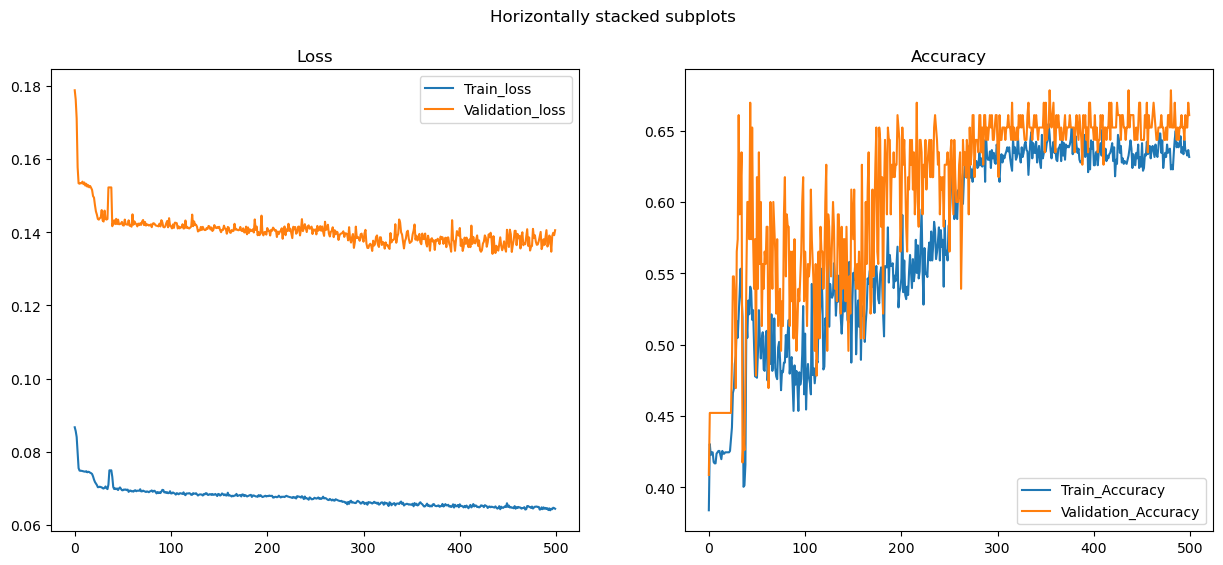

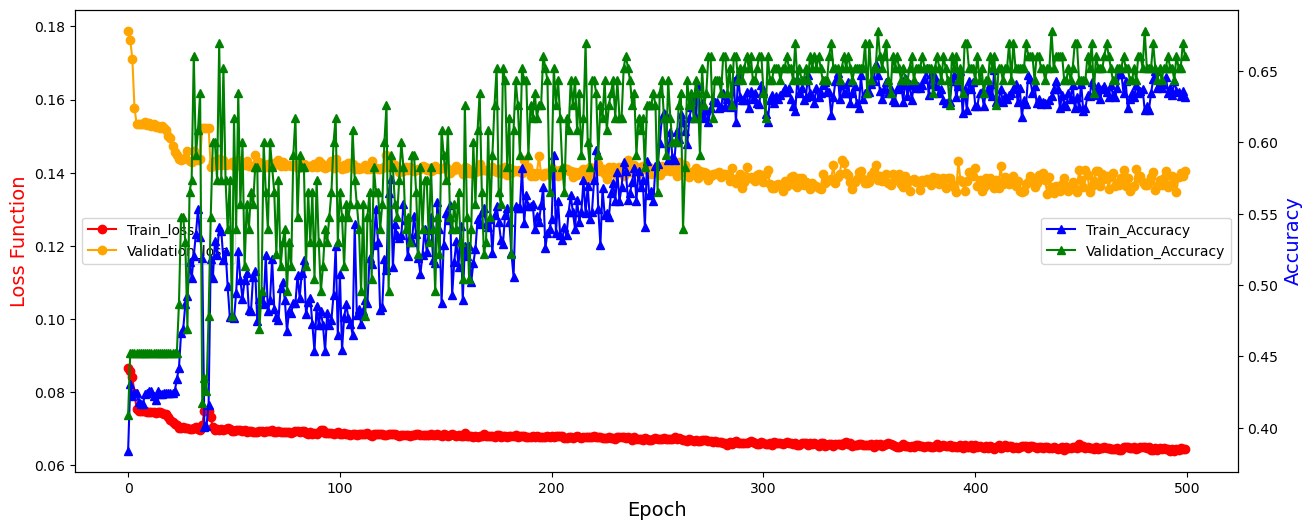

Current time: 159.100 minutes. Time expected till completion: 0.000 minutes
Finished training in: 159.101 minutes


In [15]:
#loader = train_loader # Use the train loader to train
#loader2 = valid_loader
# Main
train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

val_loss_withDataAug, val_accuracy_withDataAug = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()
        
# count time
start = time.time()
#PyTorch - Training the Model
for epoch in range(epoch_check, epochs):
    print()
    # Print current epoch
    print(f"Epoch {epoch + 1} of {epochs}")
    
    # Train model
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        # in pytorch you have assign the zero for gradien in any sub epoch
        #optim.zero_grad()
        #create the output from the CNN base on the give batch images
        out = modelpy(images)
        # count the loss function 
        loss = criterion(out, labels)
        
        ######################
        optim.zero_grad()#################
        ######################
        # count the backpropagation
        loss.backward()
        # learning
        optim.step()
        
        # add new value to the main loss
        running_loss += loss.item()
        
        # calculate accuracy
        predictions = torch.argmax(out, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total

    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)

    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        # Save Model
        print("Saving model checkpoint")
        end = time.time()
        time_elapsed = (end-start)+previous_time
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt_"+str(epoch+1)+".pth")
        
        # Cheack the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

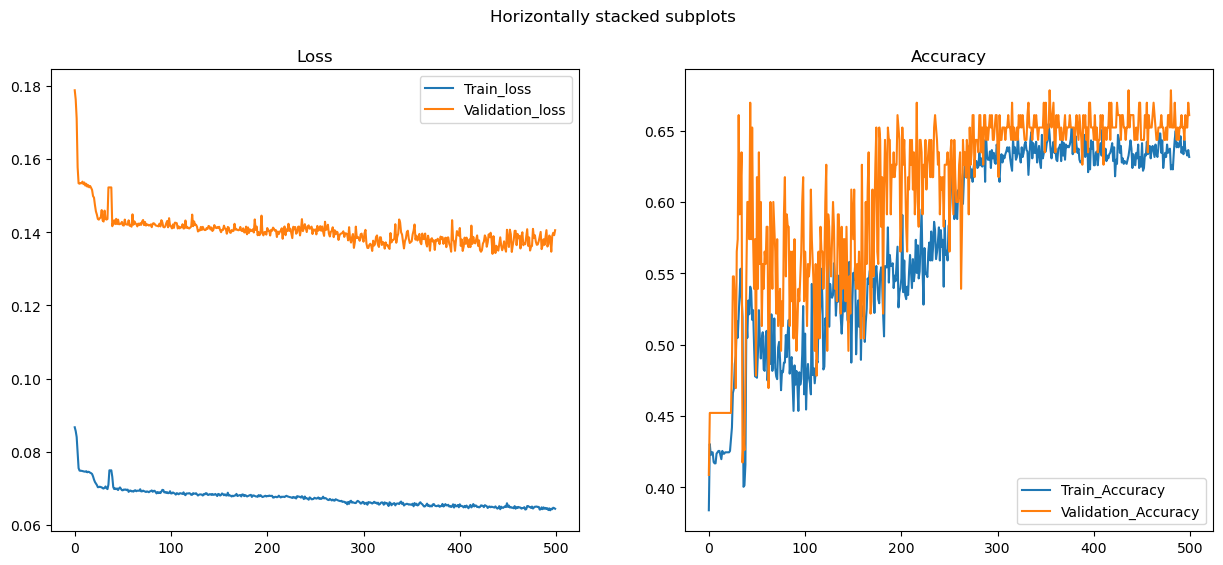

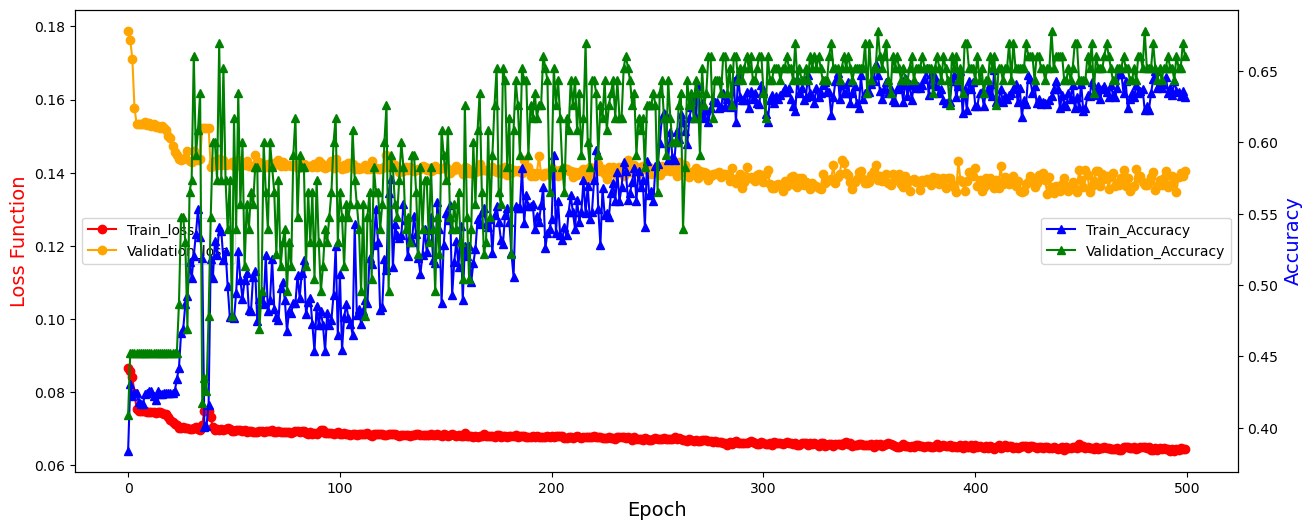

In [16]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

### Save Model

In [17]:
torch.save(modelpy.state_dict(), model_checkpoints + "saved_model_state_dict.pt")
torch.save(modelpy, model_checkpoints + "saved_model.pt")

# 3. Evaluate your model using the developed software

In [18]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy, train_loader, device, name="Train")
accuracy_given_set(modelpy, valid_loader, device, name="Validation")

Accuracy of the network on the 1034 Train instances: 64.79690522243713%
Accuracy of the network on the 115 Validation instances: 66.08695652173913%


In [19]:
# Import the test dataset
size_of_resized_img = (224,224) 
test_data, test_names = import_test_folder_dataset_2(test_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", test_data.shape)
print("Dim of Lables: ", test_names.shape)

Dim of Data:  (380, 224, 224, 3)
Dim of Lables:  (380,)


In [20]:
# Create the dataset object
test_Dataset = Data_test_2(test_data, test_names, img_transform_val)#img_transform_val
print("Test len: ",len(test_Dataset))

Test len:  380


In [21]:
# Make the predictions for the test dataset
predictions_list, names = make_predictions(modelpy=modelpy, dataset=test_Dataset, device=device)
len(predictions_list)

380

In [22]:
# Save the Predictions
save_predictions_as_csv(names=names, predictions=predictions_list, name="07_10Conv_5Res_128FChannels_0Batch.csv")

# 4. Compare results with [SCTL paper](https://www.mdpi.com/2076-2615/12/7/886/htm). Requirement: performance is better than VGG16: 66.8%

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link here.

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points